# An Analysis of the City of Toronto’s Fire Response between 2011-2019
                              
## Authors: The City of Toronto Department of Pandas
Sayna Yaghooby Namin, Jeffrey Sauer, Kevin Kuriakose Joseph, Samantha LeValley

The goal of this project is to create a predictive model capable of determining response time of Toronto Fire Service given inputs such as day, time, or location of nearest fire station. Exploratory data analysis is iterative, therefore, until our exploratory data analysis is conducted, we will not know exactly which features will be used to implement the model, nor do we know exactly what type of prediction model will be used. In this notebook, our team shows the datacleaning processes, exploratory data analysis, and implementation of machine model. For more descriptive explanation, please visit our Medium artivle here: https://medium.com/@cityoftorontopandas/6f03f08b89d4

## Setup Notebook

In [1]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import neighbors
from sklearn import tree
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
import folium
from folium.plugins import HeatMap

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')


# Overview

The primary dataset to be used for this project includes information about Toronto’s Fire Incidents (https://open.toronto.ca/dataset/fire-incidents/). This data is a .csv file from the City of Toronto’s open data portal with details of over 17,000 fire incidents between January 1, 2011, to June 30, 2019. The dataset contains 43 columns that describe the geographic location of the fire, the TFS response, impact of the fire, suspected cause, and details of the site (e.g., building condition and presence of sprinklers or alarms). The dataset contains categorical variables, many null values, and string values in many of the columns. Extensive data cleaning and data wrangling as well as feature engineering is needed for this project. Feature engineering techniques such as categorical encoding, datetime extraction, imputation, etc. will be used for this project. The appendix shows the data types and categories of each of the columns in the dataset.

The rest of the datasets described in this paragraph are secondary datasets that will only be used if time allows. The second dataset is the City of Toronto Wards data which includes spatial boundaries that we can overlay with the fire incident data for visualization purposes (https://open.toronto.ca/dataset/city-wards/). The third dataset is a .GeoJSON file with Toronto Fire station locations (https://open.toronto.ca/dataset/fire-station-locations/). 

# Import Data
Let's import the datasets.

### Toronto Fire Incidents Dataset

In [3]:
fire_data = pd.read_csv('Fire Incidents Data.csv')

In [4]:
fire_data.head(10)

_id                                     Area_of_Origin  \
0  578689                                   81 - Engine Area   
1  578690                 75 - Trash, rubbish area (outside)   
2  578691                                                NaN   
3  578692                 75 - Trash, rubbish area (outside)   
4  578693                                                NaN   
5  578694                                   81 - Engine Area   
6  578695  22 - Sleeping Area or Bedroom (inc. patients r...   
7  578696           55 - Mechanical/Electrical Services Room   
8  578697                                        28 - Office   
9  578698                                                NaN   

           Building_Status                          Business_Impact  \
0                      NaN                                      NaN   
1                      NaN                                      NaN   
2                      NaN                                      NaN   
3  01 - Normal (no change)             1 - No business interruption   
4                      NaN                                      NaN   
5                      NaN                                      NaN   
6  01 - Normal (no change)             1 - No business interruption   
7  01 - Normal (no change)  2 - May resume operations within a week   
8  01 - Normal (no change)             1 - No business interruption   
9                      NaN                                      NaN   

   Civilian_Casualties  Count_of_Persons_Rescued  Estimated_Dollar_Loss  \
0                    0                         0                15000.0   
1                    0                         0                   50.0   
2                    0                         0                    NaN   
3                    0                         0                    0.0   
4                    0                         0                    NaN   
5                    0                         0                 1500.0   
6                    0                         0                 2000.0   
7                    0                         0               100000.0   
8                    0                         0                 5000.0   
9                    0                         0                    NaN   

   Estimated_Number_Of_Persons_Displaced  Exposures  \
0                                    NaN        NaN   
1                                    NaN        NaN   
2                                    NaN        NaN   
3                                    0.0        NaN   
4                                    NaN        NaN   
5                                    NaN        NaN   
6                                    0.0        NaN   
7                                    0.0        NaN   
8                                    0.0        NaN   
9                                    NaN        NaN   

  Ext_agent_app_or_defer_time  ...  \
0         2018-02-24T21:12:00  ...   
1         2018-02-24T21:29:42  ...   
2                         NaN  ...   
3         2018-02-25T14:19:25  ...   
4                         NaN  ...   
5         2018-02-25T18:38:00  ...   
6         2018-02-26T18:28:00  ...   
7         2018-02-27T10:57:32  ...   
8         2018-02-25T15:57:00  ...   
9                         NaN  ...   

            Smoke_Alarm_at_Fire_Origin_Alarm_Failure  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  98 - Not applicable: Alarm operated OR presenc...   
4                                                NaN   
5                                                NaN   
6  98 - Not applicable: Alarm operated OR presenc...   
7  98 - Not applicable: Alarm operated OR presenc...   
8  98 - Not applicable: Alarm operated OR presenc...   
9                                                NaN   

               Smoke_Alarm_at_Fire_Origin_Alarm_Typ

In [5]:
fire_data.info() #inspecting the information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 43 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   _id                                                            17536 non-null  int64  
 1   Area_of_Origin                                                 15623 non-null  object 
 2   Building_Status                                                11216 non-null  object 
 3   Business_Impact                                                11214 non-null  object 
 4   Civilian_Casualties                                            17536 non-null  int64  
 5   Count_of_Persons_Rescued                                       17536 non-null  int64  
 6   Estimated_Dollar_Loss                                          15627 non-null  float64
 7   Estimated_Number_Of_Persons_Displaced                     

### Toronto Wards

Importing the ward map for Toronto


In [6]:
#importing the ward shapefile
ward = gpd.read_file('25-ward-model-december-2018-wgs84-latitude-longitude') #importing shapefile

# View GeoDataFrame
ward.head()

AREA_ID AREA_TYPE AREA_S_CD AREA_L_CD            AREA_NAME           X  \
0  2551040      WD18        16        16      Don Valley East  318237.290   
1  2551044      WD18        03        03  Etobicoke-Lakeshore  303099.474   
2  2551048      WD18        15        15      Don Valley West  314825.876   
3  2551052      WD18        23        23    Scarborough North  324522.149   
4  2551056      WD18        11        11  University-Rosedale  313306.543   

           Y  LONGITUDE   LATITUDE  \
0  4844000.0  -79.33298  43.739716   
1  4831000.0  -79.52087  43.621646   
2  4843000.0  -79.37536  43.728396   
3  4852000.0  -79.25467  43.809672   
4  4837000.0  -79.39432  43.671139   

                                            geometry  
0  POLYGON ((-79.31335 43.71699, -79.31950 43.715...  
1  POLYGON ((-79.49777 43.65198, -79.49725 43.651...  
2  POLYGON ((-79.35232 43.71573, -79.35209 43.715...  
3  POLYGON ((-79.22591 43.83960, -79.22556 43.839...  
4  POLYGON ((-79.39004 43.69050, -79.39004 43.690...

### Toronto Fire Station Locations

In [7]:
#importing the csv file for toronto fire station locations
fire_stations = pd.read_csv('torontofirestation_locations.csv')

#renaming column names
fire_stations = fire_stations.rename({'Latitude ': 'Lat', 'Longitude': 'Lon'}, axis = 1)

#inspecting the information of the dataset
fire_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Station Number  85 non-null     object 
 1   Address         85 non-null     object 
 2   Lat             85 non-null     float64
 3   Lon             85 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.8+ KB


In [8]:
#creating a new GeoDataFrame from fire_stations DataFrame
fire_stations_gdf = gpd.GeoDataFrame(fire_stations, geometry = gpd.points_from_xy(fire_stations.Lon, fire_stations.Lat))
fire_stations_gdf.head()

Station Number                   Address        Lat        Lon  \
0    Station 111       3300 Bayview Avenue  43.790180 -79.393326   
1    Station 112      5700 Bathurst Street  43.776370 -79.443620   
2    Station 113     700 Seneca Hill Drive  43.793220 -79.350350   
3    Station 114       12 Canterbury Place  43.772680 -79.414960   
4    Station 115  115 Parkway Forest Drive  43.774208 -79.340829   

                     geometry  
0  POINT (-79.39333 43.79018)  
1  POINT (-79.44362 43.77637)  
2  POINT (-79.35035 43.79322)  
3  POINT (-79.41496 43.77268)  
4  POINT (-79.34083 43.77421)

In [9]:
# convert to a EPSG:4326 crs
fire_stations_gdf.crs = {'init' : 'epsg:4326'}

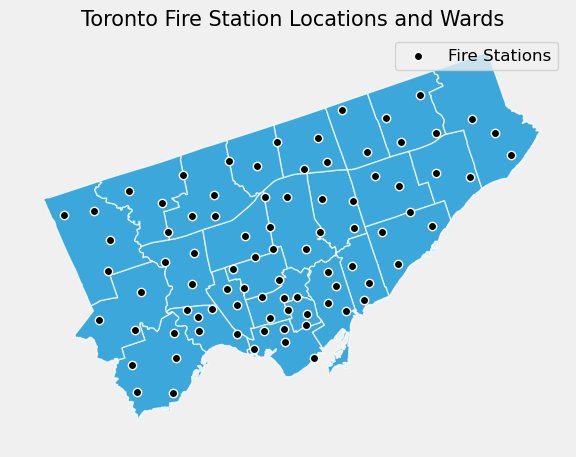

In [10]:
# Plot of the toronto fire station locations and wards
ward = ward.to_crs(epsg = 26917)   #convert to a EPSG:26917 crs
ax = ward.plot(figsize=(12, 5), edgecolor='w', alpha=0.75)  #plotting all ward in the shapefile. 

fire_stations_gdf = fire_stations_gdf.to_crs(epsg = 26917)  #convert to a EPSG:26917 crs
fire_stations_gdf.plot(ax = ax, color = 'black', edgecolor = 'w', label = 'Fire Stations')  #plotting fire_stations

plt.legend(fontsize = 12) #legend
plt.title('Toronto Fire Station Locations and Wards', fontsize = 15)  #title
ax.axes.get_xaxis().set_visible(False) #removing xaxis
ax.axes.get_yaxis().set_visible(False)  #removing yaxis

# Data Cleaning

In [11]:
#viewing dataframe before data cleaning
fire_data.head()

_id                      Area_of_Origin          Building_Status  \
0  578689                    81 - Engine Area                      NaN   
1  578690  75 - Trash, rubbish area (outside)                      NaN   
2  578691                                 NaN                      NaN   
3  578692  75 - Trash, rubbish area (outside)  01 - Normal (no change)   
4  578693                                 NaN                      NaN   

                Business_Impact  Civilian_Casualties  \
0                           NaN                    0   
1                           NaN                    0   
2                           NaN                    0   
3  1 - No business interruption                    0   
4                           NaN                    0   

   Count_of_Persons_Rescued  Estimated_Dollar_Loss  \
0                         0                15000.0   
1                         0                   50.0   
2                         0                    NaN   
3                         0                    0.0   
4                         0                    NaN   

   Estimated_Number_Of_Persons_Displaced  Exposures  \
0                                    NaN        NaN   
1                                    NaN        NaN   
2                                    NaN        NaN   
3                                    0.0        NaN   
4                                    NaN        NaN   

  Ext_agent_app_or_defer_time  ...  \
0         2018-02-24T21:12:00  ...   
1         2018-02-24T21:29:42  ...   
2                         NaN  ...   
3         2018-02-25T14:19:25  ...   
4                         NaN  ...   

            Smoke_Alarm_at_Fire_Origin_Alarm_Failure  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  98 - Not applicable: Alarm operated OR presenc...   
4                                                NaN   

  Smoke_Alarm_at_Fire_Origin_Alarm_Type  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                 9 - Type undetermined   
4                                   NaN   

  Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3   8 - Not applicable: No alarm, no persons present              
4                                                NaN              

        Smoke_Spread                        Sprinkler_System_Operation  \
0                NaN                                               NaN   
1                NaN                                               NaN   
2                NaN                                               NaN   
3  99 - Undetermined  8 - Not applicable - no sprinkler system present   
4                NaN                                               NaN   

  Sprinkler_System_Presence  \
0                       NaN   
1                       NaN   
2                       NaN   
3          9 - Undetermined   
4                       NaN   

                           Status_of_Fire_On_Arrival       TFS_Alarm_Time  \
0  7 - Fully involved (total structure, vehicle, ...  2018-02-24T21:04:29   
1              2 - Fire with no evidence from street  2018-02-24T21:24:43   
2                                                NaN  2018-02-25T13:29:59   
3  3 - Fire with smoke showing only - including v...  2018-02-25T14:13:39   
4                                                NaN  2018-02-25T18:20:43   

      TFS_Arrival_Time  TFS_Firefighter_Casualties  
0  2018-02-24T21:10:11                           0  
1  2018-02-24T21:29:31                           0  
2  2018-02-25T13:36:49                           0  
3  2018-02-25T14:18:07           

## Irrelevant Data
We decided to drop the columns below, because we believe it does not affect the response time of Toronto Fire Services reaching the incident stations. 

In [12]:
drop = ['Area_of_Origin',
        'Building_Status',
        'Business_Impact',
        'Civilian_Casualties',
        'Count_of_Persons_Rescued',
        'Estimated_Dollar_Loss',
        'Estimated_Number_Of_Persons_Displaced',
        'Exposures',
        'Extent_Of_Fire',
        'Final_Incident_Type',
        'Fire_Alarm_System_Impact_on_Evacuation',
        'Fire_Alarm_System_Operation',
        'Fire_Alarm_System_Presence',
        'Fire_Under_Control_Time',
        'Ignition_Source',
        'Incident_Number',
        'Initial_CAD_Event_Type',
        'Intersection',
        'Last_TFS_Unit_Clear_Time',
        'Level_Of_Origin',
        'Material_First_Ignited',
        'Method_Of_Fire_Control',
        'Possible_Cause',
        'Property_Use',
        'Smoke_Alarm_at_Fire_Origin',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
        'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
        'Smoke_Spread',
        'Sprinkler_System_Operation',
        'Sprinkler_System_Presence',
        'Status_of_Fire_On_Arrival',
        'Ext_agent_app_or_defer_time',
        'TFS_Firefighter_Casualties']

In [13]:
fire_data = fire_data.drop(drop, axis = 1) #dropping all the columns from fire_data
fire_data.info() #inspecting the cleaned fire_data dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             17536 non-null  int64  
 1   Incident_Station_Area           17536 non-null  int64  
 2   Incident_Ward                   17451 non-null  float64
 3   Latitude                        17535 non-null  float64
 4   Longitude                       17535 non-null  float64
 5   Number_of_responding_apparatus  17536 non-null  int64  
 6   Number_of_responding_personnel  17536 non-null  int64  
 7   TFS_Alarm_Time                  17536 non-null  object 
 8   TFS_Arrival_Time                17536 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 1.2+ MB


## Missing Data
Next, it is important to understand the number of null values and how to approach eliminating or changing those values. It appears that the columns with null values are ones where:
- We have one column missing 85 rows of data. This is the "Incident_Ward" column.
- We have four columns all missing 1 value. "Intersection", "Longitude", "Latitude", and "Property_Use".
- We have 6 columns with zero null values.

In [14]:
fire_data.isnull().sum().sort_values(ascending = False) #sorting all null values and adding them

Incident_Ward                     85
Latitude                           1
Longitude                          1
_id                                0
Incident_Station_Area              0
Number_of_responding_apparatus     0
Number_of_responding_personnel     0
TFS_Alarm_Time                     0
TFS_Arrival_Time                   0
dtype: int64

In [15]:
# Finding row that the singular Latitude, Longitude, Intersection null value is Null
fire_data[fire_data['Latitude'].isnull()]

_id  Incident_Station_Area  Incident_Ward  Latitude  Longitude  \
17500  596189                    214            NaN       NaN        NaN   

       Number_of_responding_apparatus  Number_of_responding_personnel  \
17500                               3                              10   

            TFS_Alarm_Time     TFS_Arrival_Time  
17500  2011-09-26T18:55:12  2011-09-26T19:01:00

In [16]:
# Dropping the above row, because of the null values
fire_data.drop(fire_data.index[17500], axis = 0, inplace = True)

In [17]:
# Dropping the rows with Incident_Ward values Null
fire_data.dropna(subset ='Incident_Ward',inplace=True)

#convering Incident_Ward column values as integer
fire_data['Incident_Ward'] = fire_data['Incident_Ward'].astype('int64')

## Parsing DateTimes
We have 5 columns that should be DateTimes but are currently objects. Let's convert these.

In [18]:
#columns list which should be converted to datetime columns for better usabilty.
datetime_columns = ['TFS_Alarm_Time', 'TFS_Arrival_Time']

#conversion of the above column to datetime in HH: MM: SS
fire_data[datetime_columns] = fire_data[datetime_columns].apply(pd.to_datetime, format = '%Y-%m-%d %H:%M:%S')

In [19]:
#Creating Hour, Month, Day of Week, Year columns and extracting from time column
fire_data['Hour']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.hour) #creating hour column from time column 
fire_data['Month']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.month) #creating month column from time column 
fire_data['Day of Week']=fire_data['TFS_Alarm_Time'].apply(lambda time:time.dayofweek) #creating Day of Week column from time column 
fire_data['Year'] = fire_data['TFS_Alarm_Time'].apply(lambda time:time.year) #creating Year column from time column 

In [20]:
dmap={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'} #Making the number of the days of the week into words
fire_data['Day of Week']= fire_data['Day of Week'].map(dmap) #mapping the above values to the respective values

## Check for Duplicates

In [21]:
fire_data.duplicated().sum() #calculating the number of duplicates

0

## Converting Incidents Data to GeoDataFrame

In [22]:
#converting the firedata with latittudes and longitudes data into a GeoDataFrame
fire_data = gpd.GeoDataFrame(fire_data,
                             geometry = gpd.points_from_xy(fire_data.Longitude, fire_data.Latitude))

fire_data.head()

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
0  578689                    441              1  43.686558 -79.599419   
1  578690                    116             18  43.766135 -79.390039   
2  578691                    221             21  43.743230 -79.245061   
3  578692                    133              5  43.708659 -79.478062   
4  578693                    132              8  43.718118 -79.443184   

   Number_of_responding_apparatus  Number_of_responding_personnel  \
0                               1                               4   
1                               1                               4   
2                               6                              22   
3                               6                              22   
4                               6                              22   

       TFS_Alarm_Time    TFS_Arrival_Time  Hour  Month Day of Week  Year  \
0 2018-02-24 21:04:29 2018-02-24 21:10:11    21      2         Sat  2018   
1 2018-02-24 21:24:43 2018-02-24 21:29:31    21      2         Sat  2018   
2 2018-02-25 13:29:59 2018-02-25 13:36:49    13      2         Sun  2018   
3 2018-02-25 14:13:39 2018-02-25 14:18:07    14      2         Sun  2018   
4 2018-02-25 18:20:43 2018-02-25 18:26:19    18      2         Sun  2018   

                     geometry  
0  POINT (-79.59942 43.68656)  
1  POINT (-79.39004 43.76613)  
2  POINT (-79.24506 43.74323)  
3  POINT (-79.47806 43.70866)  
4  POINT (-79.44318 43.71812)

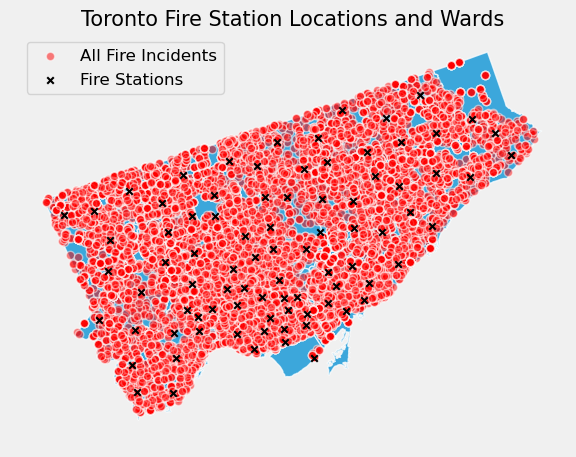

In [23]:
# Plot of the toronto fire station locations and wards
fire_data.crs = {'init' : 'epsg:4326'}  #converting the crs of fire_data to EPSG:4326

ward = ward.to_crs(epsg = 26917)#converting the crs of ward to EPSG:26917

ax = ward.plot(figsize=(12, 5), edgecolor='w', alpha=0.75) #plotting ward map

fire_data = fire_data.to_crs(epsg = 26917)  #converting the crs of fire_data to EPSG:26917

fire_data.plot(ax = ax, color = 'red', alpha = 0.5, edgecolor = 'w', label = 'All Fire Incidents') #plotting fire_data
fire_stations_gdf = fire_stations_gdf.to_crs(epsg = 26917) #converting the crs of fire_stations_gdf to EPSG:26917
fire_stations_gdf.plot(ax = ax, color = 'black', edgecolor = 'w', marker='x',  markersize=22, label = 'Fire Stations') #plotting the firestations with black marker

plt.legend(fontsize = 12) #legend
plt.title('Toronto Fire Station Locations and Wards', fontsize = 15)  #title
ax.axes.get_xaxis().set_visible(False) #removing the axis from the plot
ax.axes.get_yaxis().set_visible(False) #removing the axis from the plot

In [24]:
# Heat Map of Toronto Fire Incidents
heat_map = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron', 
                   zoom_start=10)

# Add points to the map
HeatMap(data=list(zip(fire_data.to_crs(epsg=4326).geometry.y,
                      fire_data.to_crs(epsg=4326).geometry.x)),min_opacity=0.4,radius=20, blur = 18).add_to(heat_map)

# Display map
heat_map

# Exploratory Data Analysis (EDA)

The Target variable is Response Time. We define it as 𝑅𝑒𝑠𝑝𝑜𝑛𝑠𝑒 𝑇𝑖𝑚𝑒=𝑇𝐹𝑆 𝐴𝑟𝑟𝑖𝑣𝑎𝑙 𝑇𝑖𝑚𝑒−𝑇𝐹𝑆 𝐴𝑙𝑎𝑟𝑚 𝑇𝑖𝑚𝑒

### Calculating Response Time

In [25]:
fire_data['response_time(min)'] =fire_data['TFS_Arrival_Time'] - fire_data['TFS_Alarm_Time']
fire_data['response_time(min)'] = fire_data['response_time(min)'].dt.total_seconds()/60

#### Responding  Apparatus

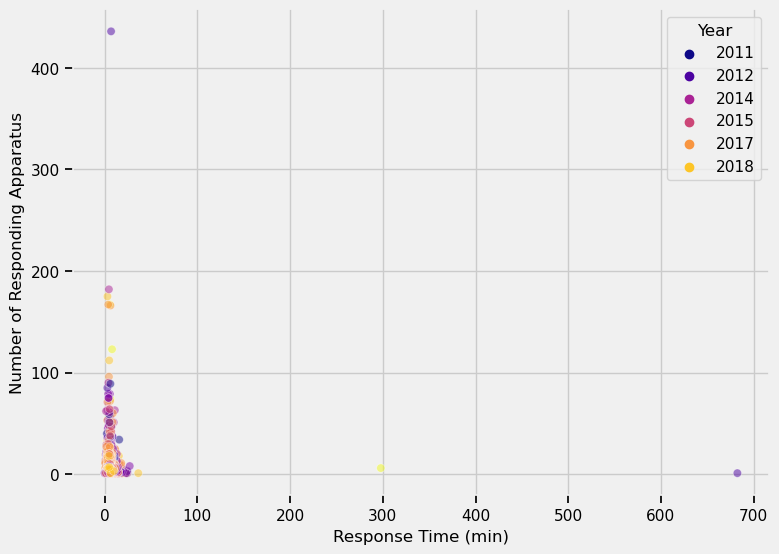

In [26]:
# Plotting the Number of Apparatus
plt.figure(figsize= (8,6)) #figsize
sns.scatterplot(data = fire_data,
                x = 'response_time(min)',
                y = 'Number_of_responding_apparatus',
                hue = 'Year',
                alpha = 0.5,
                palette = 'plasma') #plotting the responding apparatus from dataframe

plt.xlabel('Response Time (min)')
plt.ylabel('Number of Responding Apparatus')

plt.show()

#### Responding Personnel

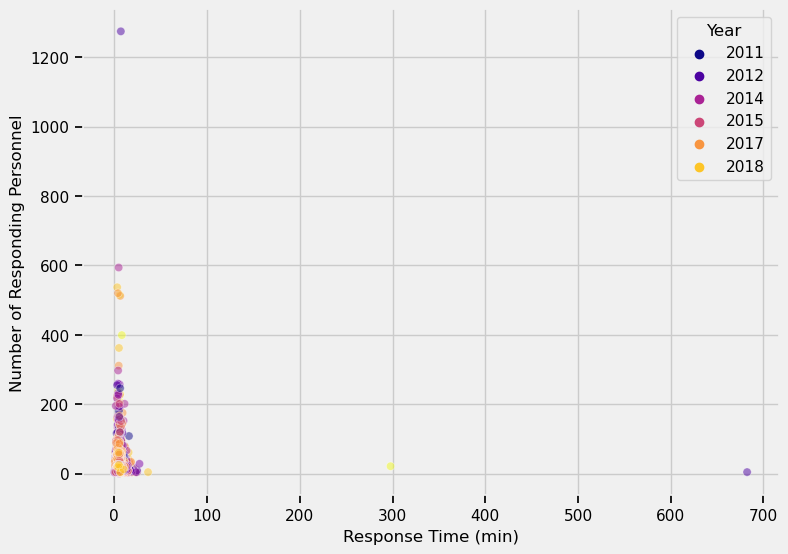

In [27]:
# Plotting the Number of Personnel
plt.figure(figsize= (8,6)) #figure size
sns.scatterplot(data = fire_data,
                x = 'response_time(min)',
                y = 'Number_of_responding_personnel',
                hue = 'Year',
                alpha = 0.5,
                palette = 'plasma') #plotting Number_of_responding_personnel and response time

plt.xlabel('Response Time (min)')
plt.ylabel('Number of Responding Personnel')

plt.show()

## Geospatial Relationships

### Distance between Incidents and Stations

In [28]:
fire_stations_gdf['Station Number Only'] = fire_stations_gdf['Station Number'].str.extract('(\d+)').astype(int) #extracting the station number from Station Number coliumn

In [29]:
fire_data = fire_data.merge(fire_stations_gdf, left_on = 'Incident_Station_Area', right_on = 'Station Number Only') #merge fire_data and fire_stations_gdf
fire_data = fire_data.rename({'Lat': 'Station_Latitude',
                              'Lon': 'Station_Longitude'}) #rename columns
fire_data = fire_data.drop(['Station Number', 'Address', 'Station Number Only'], axis = 1) #dropping columns
fire_data.head()

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
0  578689                    441              1  43.686558 -79.599419   
1  578713                    441              1  43.709060 -79.587257   
2  578751                    441              2  43.692901 -79.554025   
3  578775                    441              1  43.677783 -79.574299   
4  578821                    441              2  43.689956 -79.563768   

   Number_of_responding_apparatus  Number_of_responding_personnel  \
0                               1                               4   
1                               3                              11   
2                              10                              36   
3                               4                              14   
4                               1                               4   

       TFS_Alarm_Time    TFS_Arrival_Time  Hour  Month Day of Week  Year  \
0 2018-02-24 21:04:29 2018-02-24 21:10:11    21      2         Sat  2018   
1 2018-01-04 20:25:55 2018-01-04 20:32:05    20      1         Thu  2018   
2 2018-01-23 08:08:00 2018-01-23 08:13:11     8      1         Tue  2018   
3 2018-03-30 02:04:03 2018-03-30 02:09:29     2      3         Fri  2018   
4 2018-02-17 10:49:37 2018-02-17 10:54:29    10      2         Sat  2018   

                       geometry_x  response_time(min)       Lat       Lon  \
0  POINT (612880.315 4838013.557)            5.700000  43.69484 -79.57237   
1  POINT (613817.932 4840529.319)            6.166667  43.69484 -79.57237   
2  POINT (616526.601 4838780.854)            5.183333  43.69484 -79.57237   
3  POINT (614921.680 4837073.466)            5.433333  43.69484 -79.57237   
4  POINT (615747.136 4838440.078)            4.866667  43.69484 -79.57237   

                       geometry_y  
0  POINT (615044.544 4838970.536)  
1  POINT (615044.544 4838970.536)  
2  POINT (615044.544 4838970.536)  
3  POINT (615044.544 4838970.536)  
4  POINT (615044.544 4838970.536)

In [30]:
from math import radians, cos, sin, asin, sqrt #importing all the libraries

def haversine_np(lon1, lat1, lon2, lat2):
  
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) #mapping all the values lon1, lat1, lon2, lat2 in radians

    dlon = lon2 - lon1 #calculating longitude
    dlat = lat2 - lat1 #calculating latitude

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    
    return km

In [31]:
fire_data['Incident_Station_Distance(km)'] = haversine_np(fire_data['Longitude'],
                                                                fire_data['Latitude'],
                                                                fire_data['Lon'],
                                                                fire_data['Lat']) #calling the function and calculating distance
fire_data.head()

_id  Incident_Station_Area  Incident_Ward   Latitude  Longitude  \
0  578689                    441              1  43.686558 -79.599419   
1  578713                    441              1  43.709060 -79.587257   
2  578751                    441              2  43.692901 -79.554025   
3  578775                    441              1  43.677783 -79.574299   
4  578821                    441              2  43.689956 -79.563768   

   Number_of_responding_apparatus  Number_of_responding_personnel  \
0                               1                               4   
1                               3                              11   
2                              10                              36   
3                               4                              14   
4                               1                               4   

       TFS_Alarm_Time    TFS_Arrival_Time  Hour  Month Day of Week  Year  \
0 2018-02-24 21:04:29 2018-02-24 21:10:11    21      2         Sat  2018   
1 2018-01-04 20:25:55 2018-01-04 20:32:05    20      1         Thu  2018   
2 2018-01-23 08:08:00 2018-01-23 08:13:11     8      1         Tue  2018   
3 2018-03-30 02:04:03 2018-03-30 02:09:29     2      3         Fri  2018   
4 2018-02-17 10:49:37 2018-02-17 10:54:29    10      2         Sat  2018   

                       geometry_x  response_time(min)       Lat       Lon  \
0  POINT (612880.315 4838013.557)            5.700000  43.69484 -79.57237   
1  POINT (613817.932 4840529.319)            6.166667  43.69484 -79.57237   
2  POINT (616526.601 4838780.854)            5.183333  43.69484 -79.57237   
3  POINT (614921.680 4837073.466)            5.433333  43.69484 -79.57237   
4  POINT (615747.136 4838440.078)            4.866667  43.69484 -79.57237   

                       geometry_y  Incident_Station_Distance(km)  
0  POINT (615044.544 4838970.536)                       2.360284  
1  POINT (615044.544 4838970.536)                       1.981790  
2  POINT (615044.544 4838970.536)                       1.489613  
3  POINT (615044.544 4838970.536)                       1.901776  
4  POINT (615044.544 4838970.536)                       0.878794

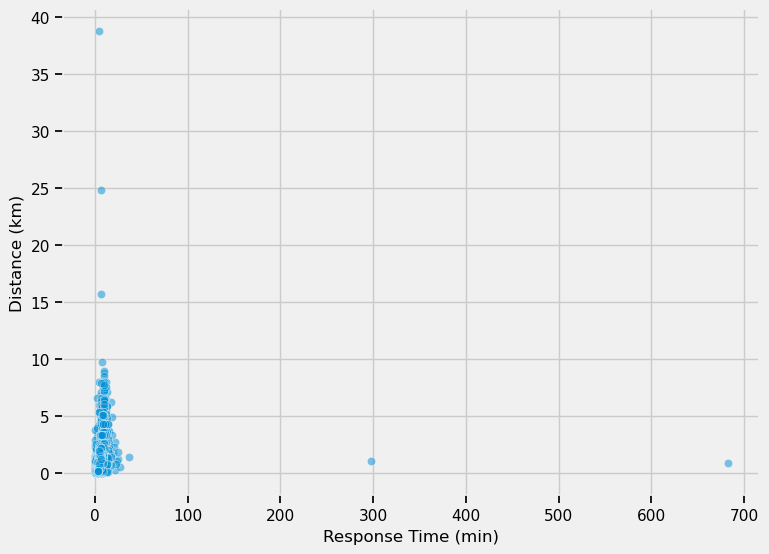

In [32]:
# Plotting distance from incident to fire station
plt.figure(figsize= (8,6))
sns.scatterplot(data = fire_data, x = 'response_time(min)', y = 'Incident_Station_Distance(km)', alpha = 0.5, palette = 'plasma')

plt.xlabel('Response Time (min)')
plt.ylabel('Distance (km)')

plt.show()

In [33]:
# Removing the outliers shown in the plot above
fire_data = fire_data[~(fire_data['response_time(min)'] > 20)]
fire_data = fire_data[~(fire_data['Incident_Station_Distance(km)'] > 10)]

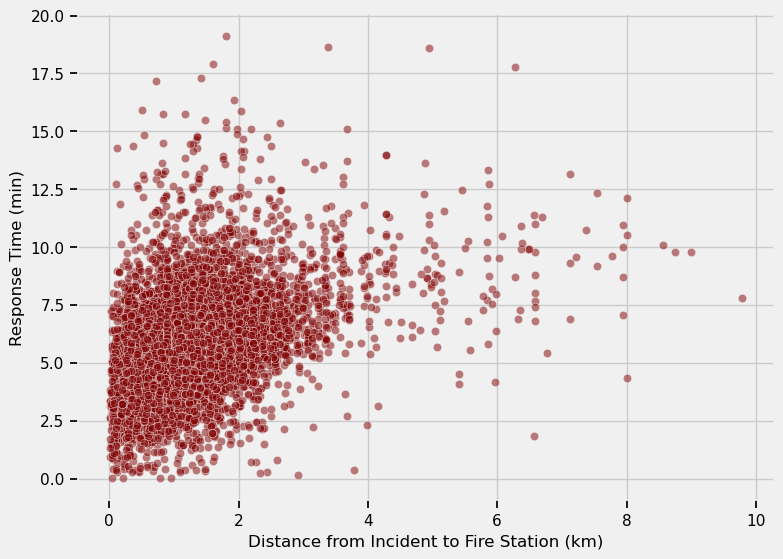

In [34]:
#Distance from Incident to Fire Station (km) vs Response Time (min) after removing outliers
plt.figure(figsize= (8,6)) #figure size
sns.scatterplot(data = fire_data,
                y = 'response_time(min)',
                x = 'Incident_Station_Distance(km)', color = ["maroon"],
                alpha = 0.5) #plotting

plt.ylabel('Response Time (min)') #ylabel
plt.xlabel('Distance from Incident to Fire Station (km)') #xlabel

plt.show()

### Comparing Different Stations' Performance

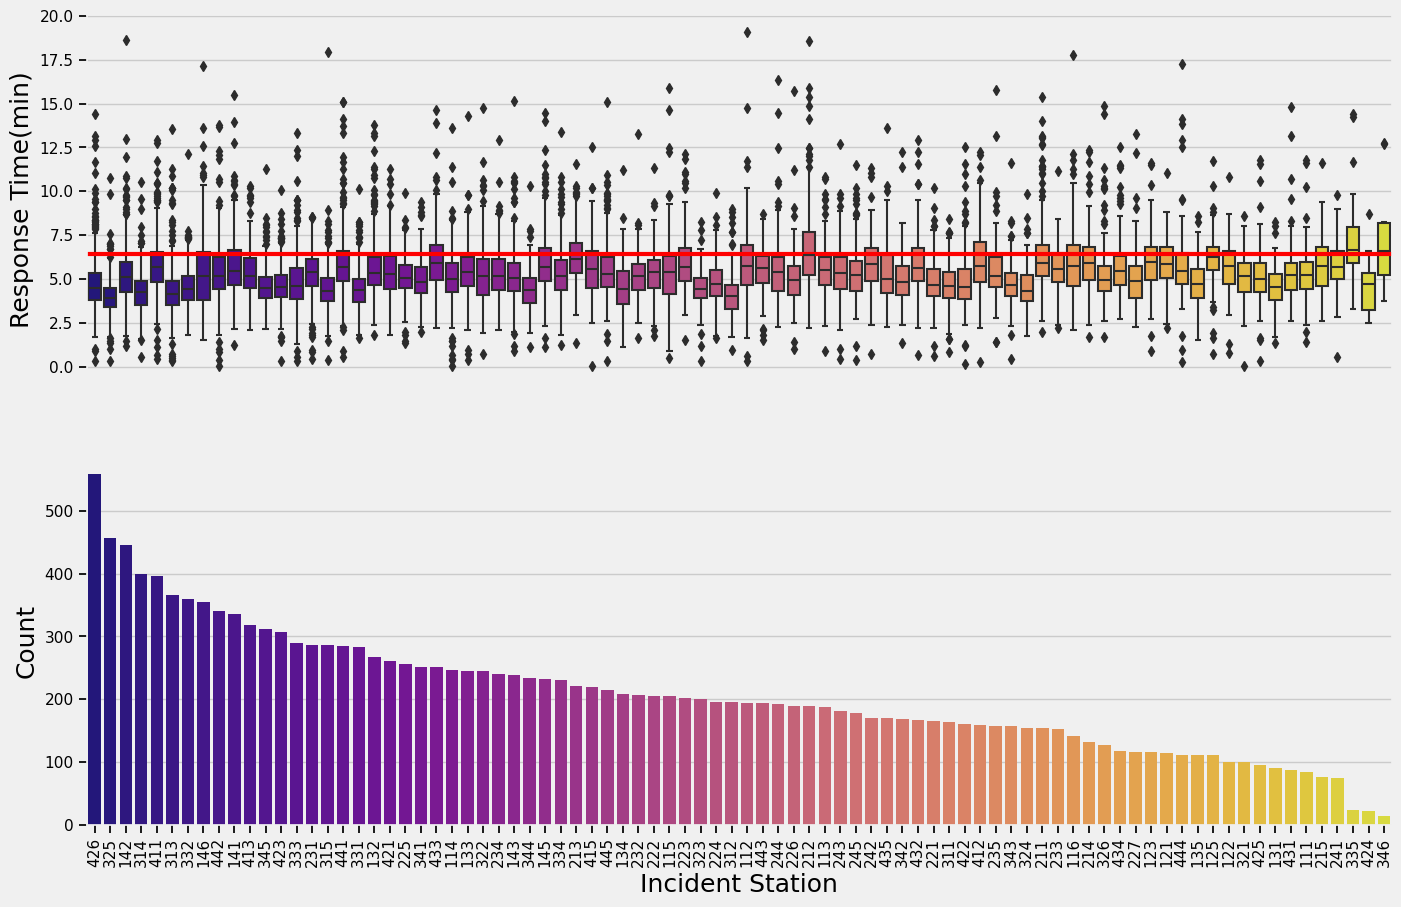

In [35]:
#box plot and count plot

response_time = 6 + (24/60) #NFPA standard 6.24 min red plot

fig, axs = plt.subplots(nrows = 2, figsize = (15,10)) #subplots

fig1 = sns.boxplot(data = fire_data,
            x = 'Incident_Station_Area',
            y = 'response_time(min)',palette='plasma',order = fire_data['Incident_Station_Area'].value_counts().index,
           ax = axs[0]) #plotting

fig1.set_ylabel('Response Time(min)', fontsize = 18) #ylabel


sns.countplot(x = 'Incident_Station_Area',
             data = fire_data,palette='plasma', order = fire_data['Incident_Station_Area'].value_counts().index,
             ax = axs[1]) #countplot

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3) #redline code

axs[0].xaxis.set_visible(False) #remove xaxis gridline
axs[1].tick_params(axis = 'x', rotation = 90)

plt.xlabel('Incident Station', fontsize = 18)#xlabel
plt.ylabel('Count', fontsize = 18)#ylabel

plt.show()

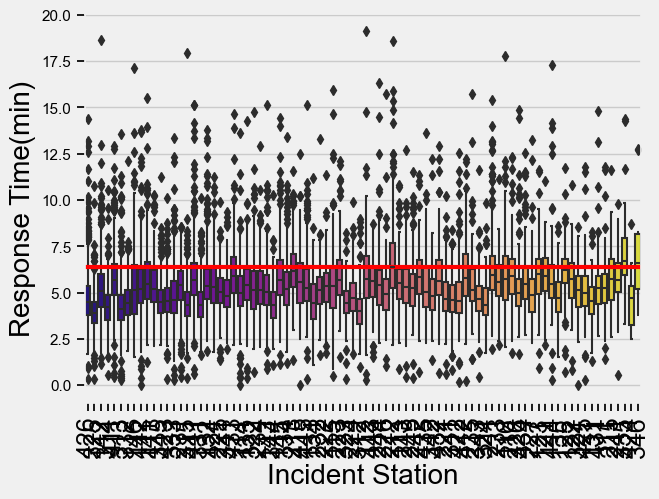

In [36]:
#box plot
response_time = 6 + (24/60) #NFPA standard 6.24 min red plot

fig1 = sns.boxplot(data = fire_data,
            x = 'Incident_Station_Area',
            y = 'response_time(min)',palette='plasma',order = fire_data['Incident_Station_Area'].value_counts().index) #plotting




fig1.axhline(y = response_time,
              color = 'red',
              linewidth=3) #redline code

sns.set(rc = {'figure.figsize': (28,11)}) #figsize


plt.xlabel('Incident Station', fontsize = 20)#xlabel
plt.ylabel('Response Time(min)', fontsize = 20)#ylabel
fig1.tick_params(axis = 'x', rotation = 90)#xticks params
plt.xticks(fontsize=18)#xticks font

plt.show()

### Incident Ward

### Pre 2018 data

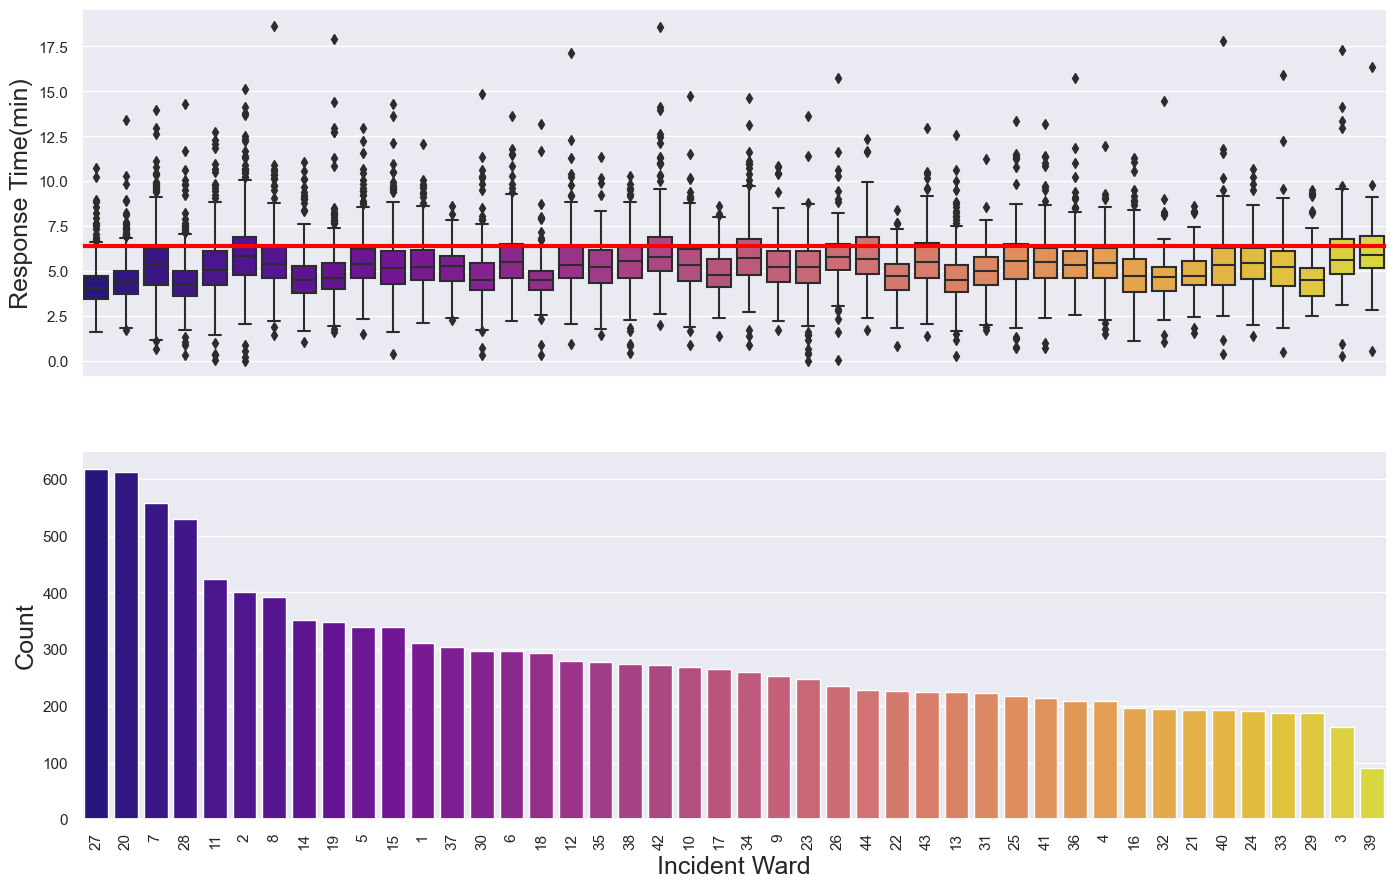

In [37]:
#box plot and count plot
response_time = 6 + (24/60) #NFPA standard 6.24 min red plot
fire_data_pre_2018 = fire_data[fire_data['Year'] < 2018]#creating dataframe before 2018
fig, axs = plt.subplots(nrows = 2, figsize = (15,10))#subplots

fig1 = sns.boxplot(data = fire_data_pre_2018,
            x = fire_data_pre_2018['Incident_Ward'],
            y = fire_data_pre_2018['response_time(min)'],palette='plasma',
           ax = axs[0],order = fire_data_pre_2018['Incident_Ward'].value_counts().index)#plotting

fig1.set_ylabel('Response Time(min)',  fontsize = 18) #ylabel


sns.countplot(x = fire_data_pre_2018['Incident_Ward'],
             data = fire_data_pre_2018,palette='plasma',
             ax = axs[1], order = fire_data_pre_2018['Incident_Ward'].value_counts().index)#plotting

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)#red line

axs[0].xaxis.set_visible(False) #hiding xgridlines
axs[1].tick_params(axis = 'x', rotation = 90) #xticks
plt.xlabel('Incident Ward' ,  fontsize = 18)#xlabel
plt.ylabel('Count',  fontsize = 18)#ylabel

plt.show()

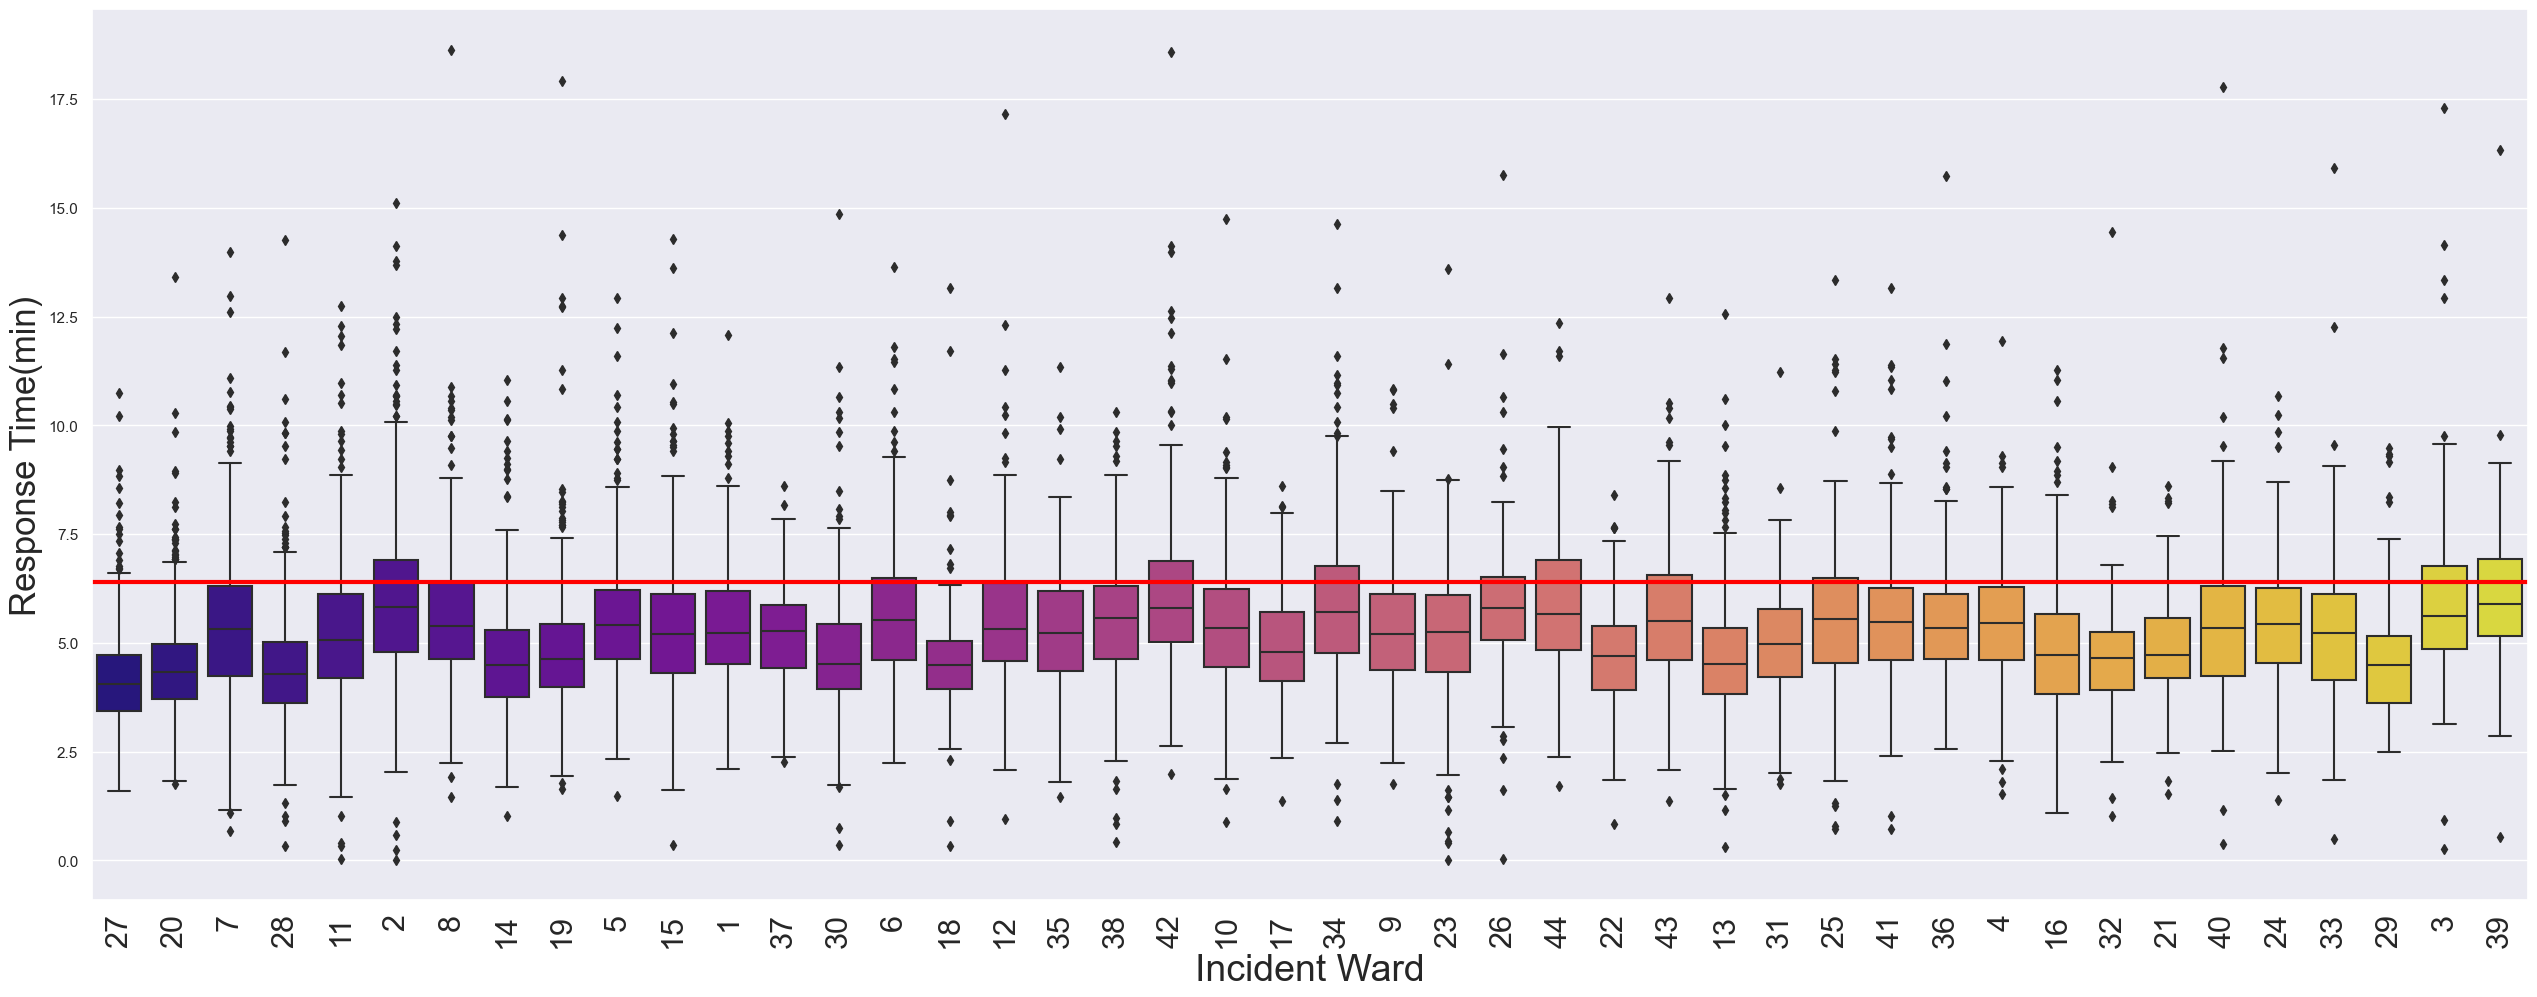

In [38]:
#only box plot
fire_data_pre_2018 = fire_data[fire_data['Year'] < 2018]#creating dataframe before 2018


fig1 = sns.boxplot(data = fire_data_pre_2018,
            x = fire_data_pre_2018['Incident_Ward'],
            y = fire_data_pre_2018['response_time(min)'],palette='plasma',
           order = fire_data_pre_2018['Incident_Ward'].value_counts().index) #boxplot

fig1.axhline(y = response_time,
              color = 'red',
              linewidth=3)#redline


sns.set(rc = {'figure.figsize': (28,11)}) #figsize
plt.xlabel('Incident Ward' ,  fontsize = 27)#xlabel
plt.ylabel('Response Time(min)',  fontsize = 25)#ylabel
fig1.tick_params(axis = 'x', rotation = 90)#xticks params
plt.xticks(fontsize=22)#xticks font

plt.show()

### Including 2018 data

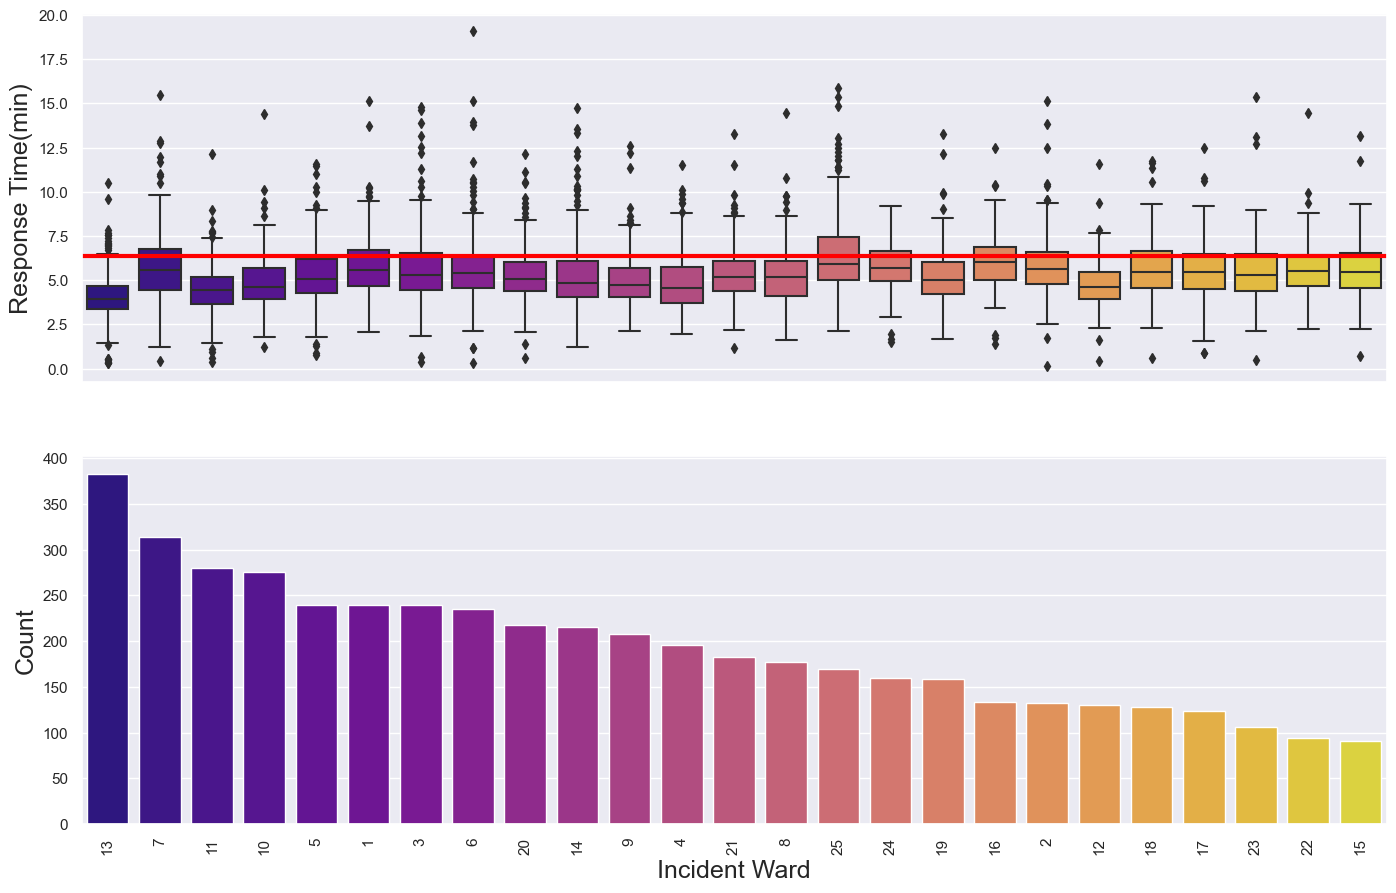

In [39]:
#box plot and the count plot
response_time = 6 + (24/60) #NFPA standard 6.24 min red plot
fire_data_pre_2018 = fire_data[fire_data['Year'] >= 2018]#creating dataframe after 2018
fig, axs = plt.subplots(nrows = 2, figsize = (15,10))

fig1 = sns.boxplot(data = fire_data_pre_2018,
            x = fire_data_pre_2018['Incident_Ward'],
            y = fire_data_pre_2018['response_time(min)'],palette='plasma',
           ax = axs[0],order = fire_data_pre_2018['Incident_Ward'].value_counts().index)

fig1.set_ylabel('Response Time(min)',  fontsize = 18) #ylabel


sns.countplot(x = fire_data_pre_2018['Incident_Ward'],
             data = fire_data_pre_2018,palette='plasma',
             ax = axs[1], order = fire_data_pre_2018['Incident_Ward'].value_counts().index)

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3) #redline



axs[0].xaxis.set_visible(False)#hiding xaxis gridlines
axs[1].tick_params(axis = 'x', rotation = 90)
plt.xlabel('Incident Ward' ,  fontsize = 18)#xlabel
plt.ylabel('Count',  fontsize = 18)#ylabel

plt.show()

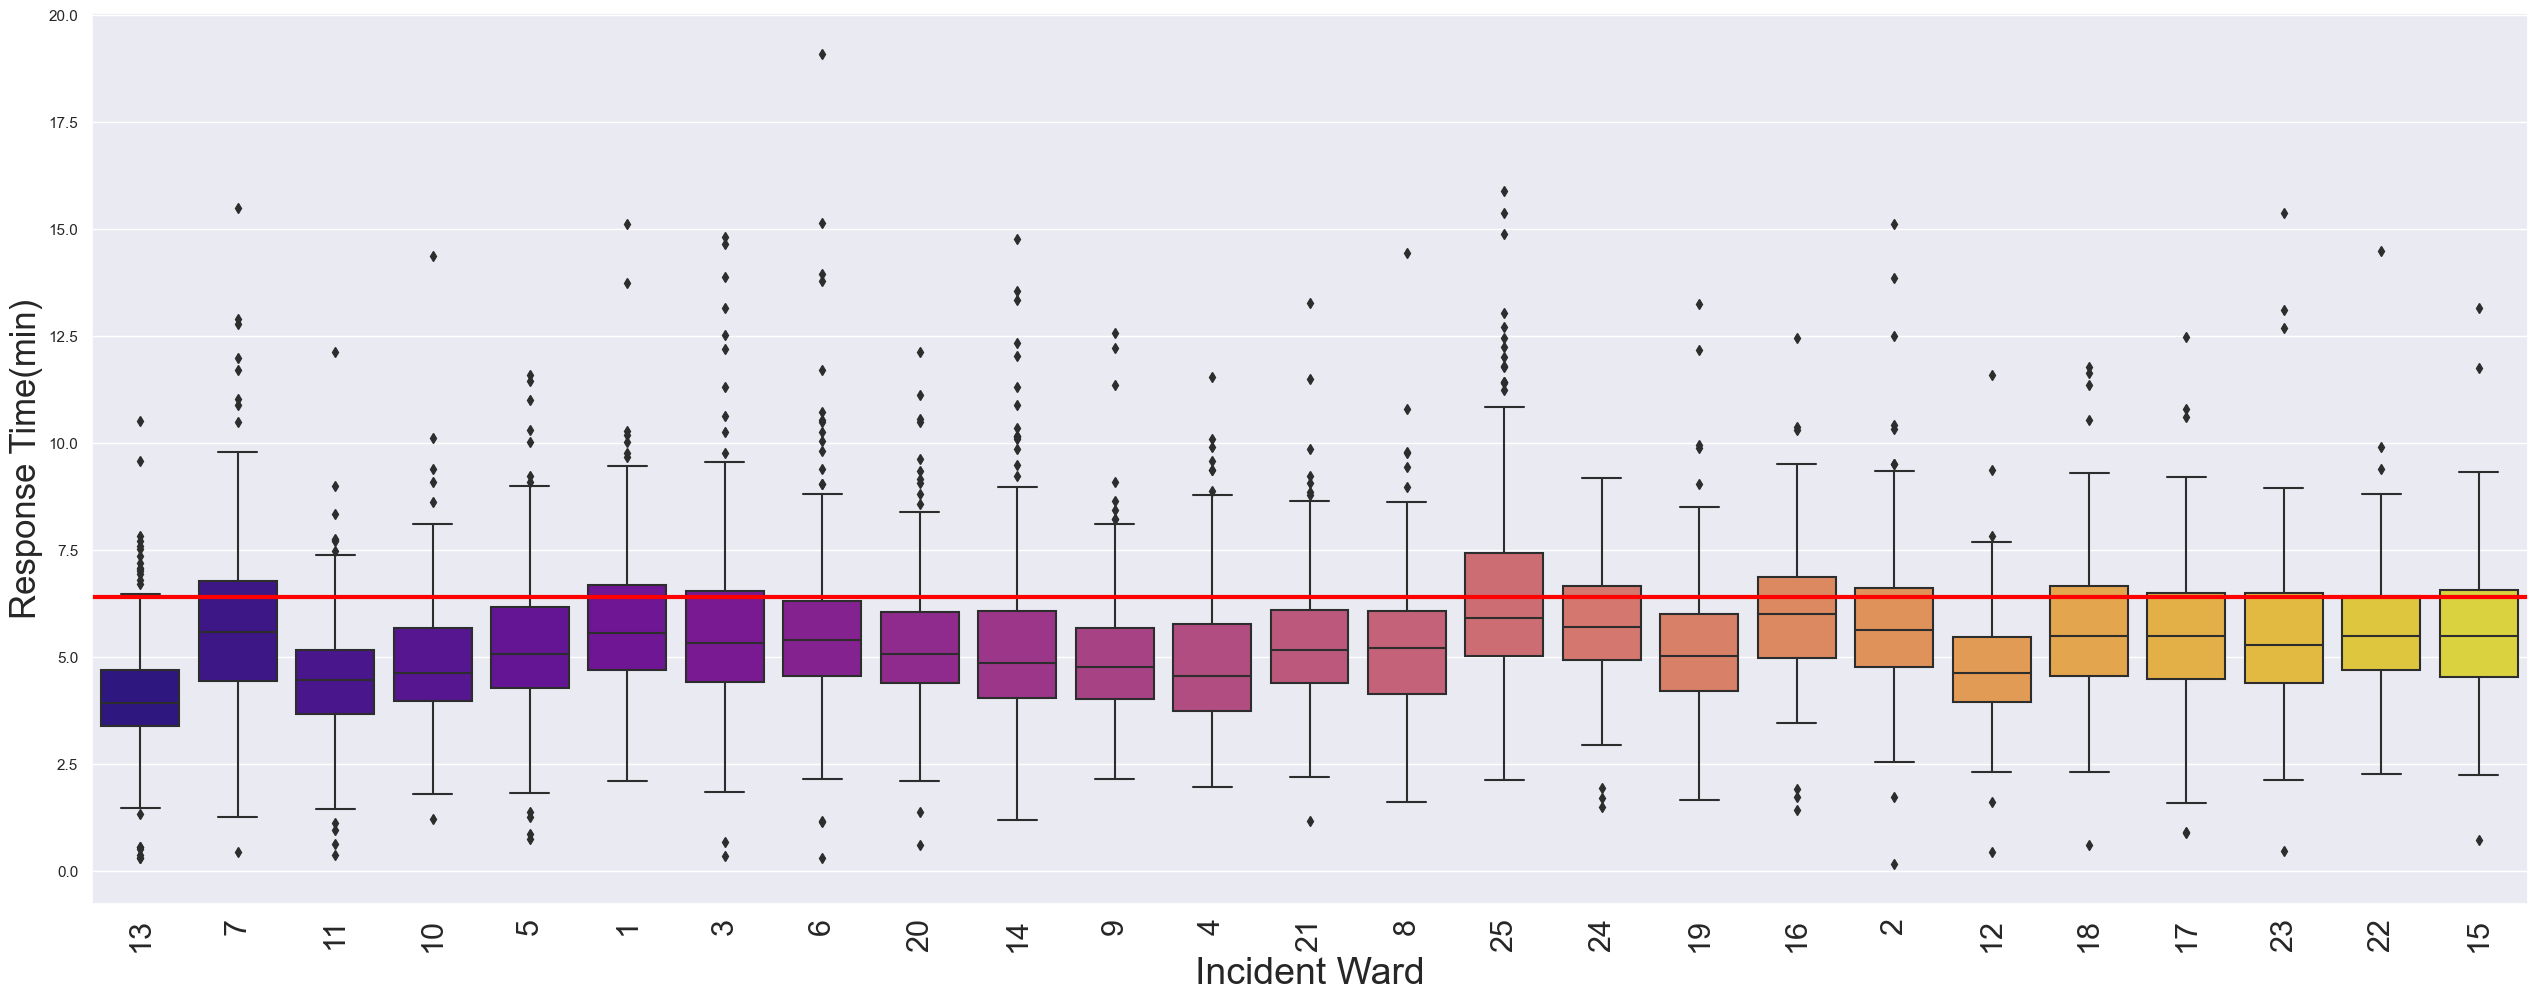

In [40]:
#only box plot
response_time = 6 + (24/60) #NFPA standard 6.24 min red plot
fire_data_pre_2018 = fire_data[fire_data['Year'] >= 2018] #creating dataframe post 2018


fig1 = sns.boxplot(data = fire_data_pre_2018,
            x = fire_data_pre_2018['Incident_Ward'],
            y = fire_data_pre_2018['response_time(min)'],palette='plasma',
           order = fire_data_pre_2018['Incident_Ward'].value_counts().index) #plotting


fig1.axhline(y = response_time,
              color = 'red',
              linewidth=3) #redline

sns.set(rc = {'figure.figsize': (28,11)}) #figsize

axs[0].xaxis.set_visible(False)
axs[1].tick_params(axis = 'x', rotation = 90)
plt.xlabel('Incident Ward' ,  fontsize = 27)#xlabel
plt.ylabel('Response Time(min)',  fontsize = 25)#ylabel

fig1.tick_params(axis = 'x', rotation = 90) #xticks
plt.xticks(fontsize=22)#xticks font


plt.show()#plot

## Temporal Analysis

#### Day of Incident

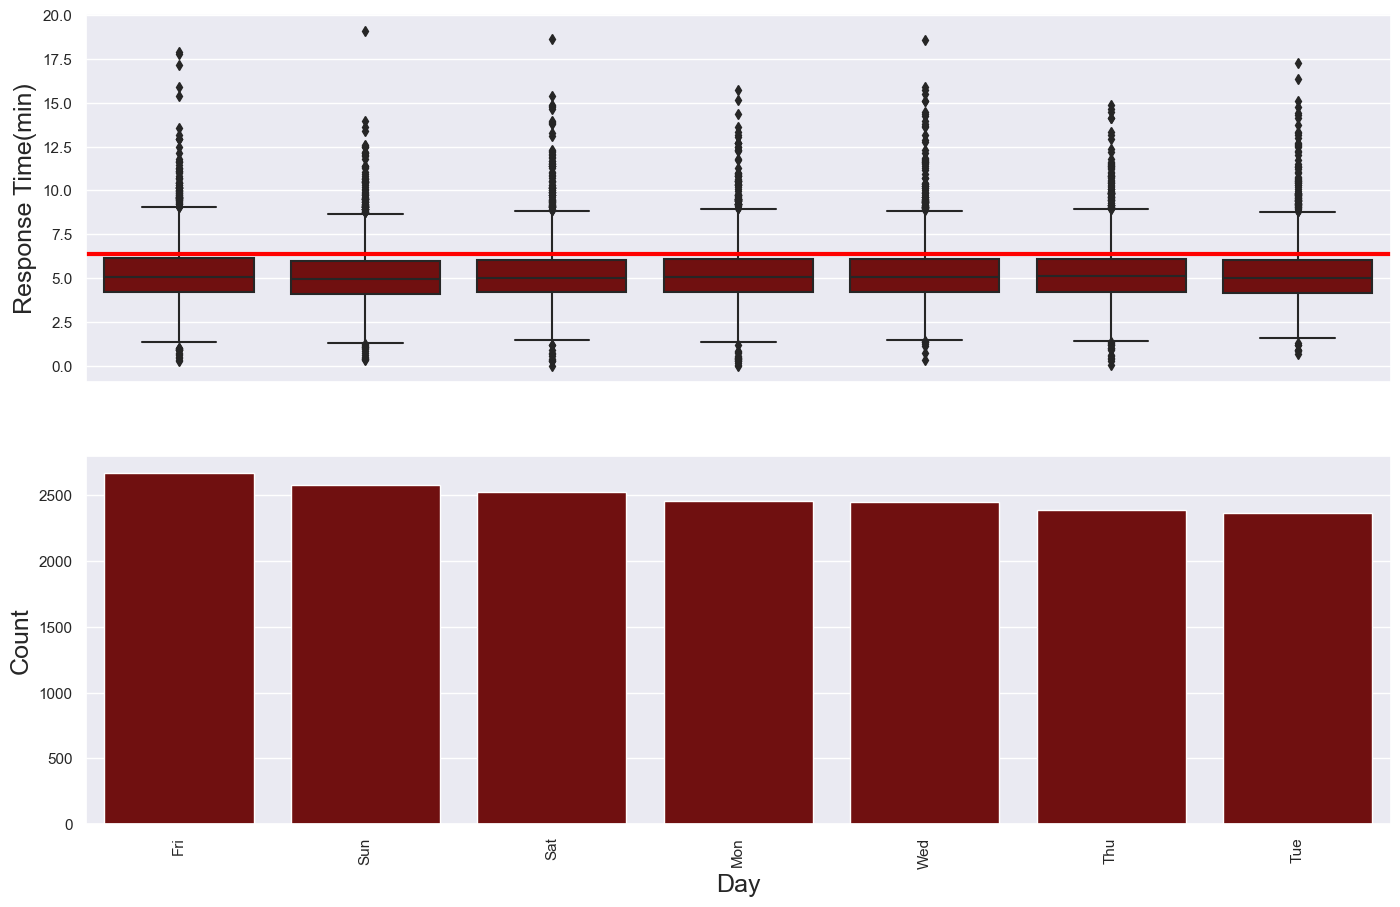

In [41]:
response_time = 6 + (24/60)  #NFPA standard 6.24 min red plot

fig, axs = plt.subplots(nrows = 2, figsize = (15,10)) #subplots

fig1 = sns.boxplot(data = fire_data,
            x = 'Day of Week',
            y = 'response_time(min)',color='maroon', order = fire_data['Day of Week'].value_counts().index, 
           ax = axs[0])#plotting

fig1.set_ylabel('Response Time(min)', fontsize = 18)#ylabel


sns.countplot(x = 'Day of Week',
             data = fire_data,color='maroon', order = fire_data['Day of Week'].value_counts().index, 
             ax = axs[1])#plotting

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3) #redline

axs[0].xaxis.set_visible(False)#hiding xgridlines
axs[1].tick_params(axis = 'x', rotation = 90) #xticks
plt.xlabel('Day', fontsize = 18) #xlabel
plt.ylabel('Count', fontsize = 18)#ylabel

plt.show()

#### Month

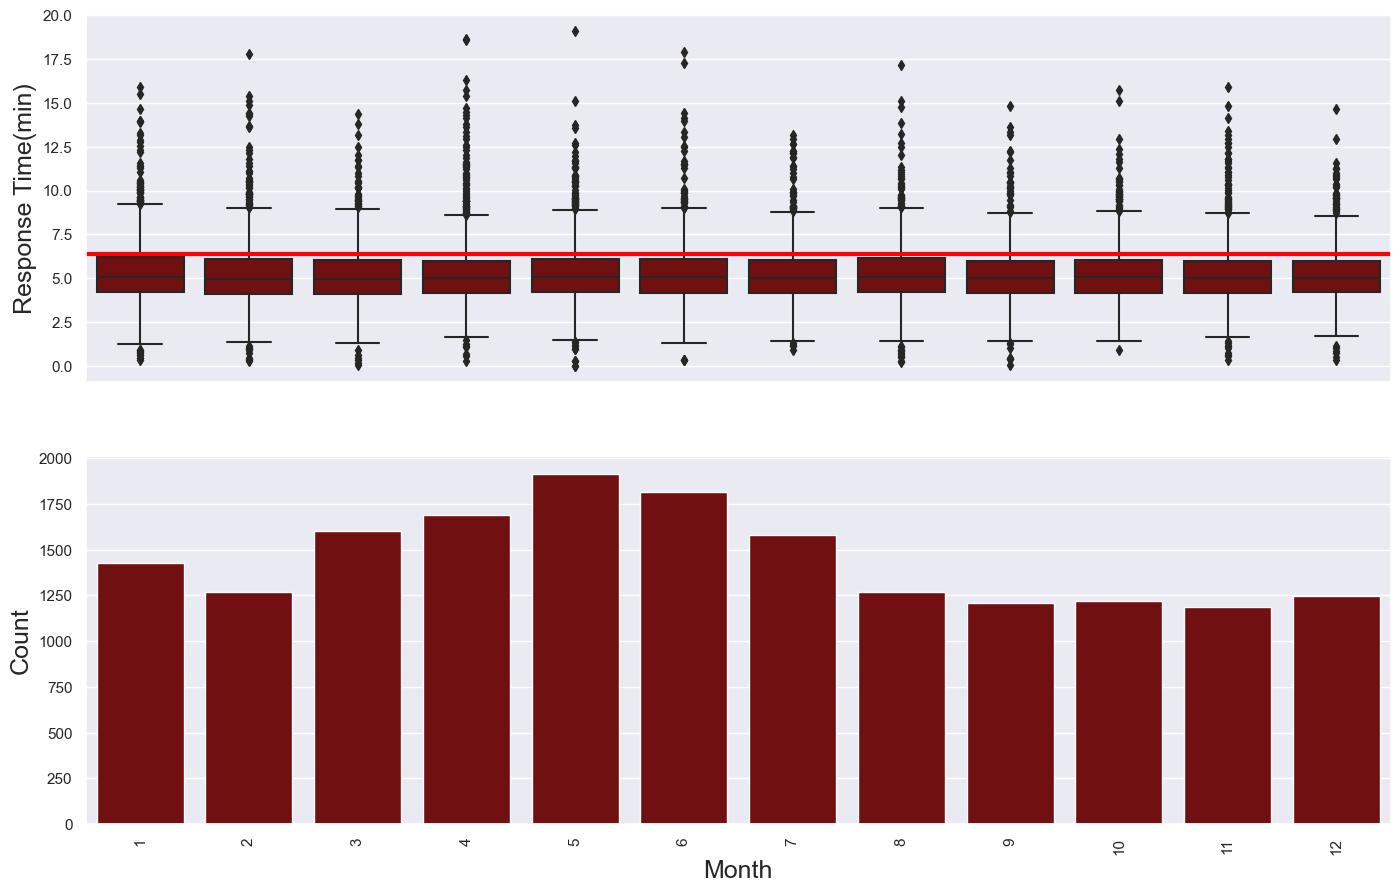

In [42]:
response_time = 6 + (24/60)

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))#subplots

fig1 = sns.boxplot(data = fire_data,
            x = 'Month',
            y = 'response_time(min)',color='maroon', order = fire_data['Month'].value_counts().index, 
           ax = axs[0])#plotting

fig1.set_ylabel('Response Time(min)', fontsize = 18)#ylabel


sns.countplot(x = 'Month',
             data = fire_data,color='maroon',
             ax = axs[1])#plotting

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)#redline



axs[0].xaxis.set_visible(False)#hiding the xgridlines
axs[1].tick_params(axis = 'x', rotation = 90)#xticks
plt.xlabel('Month', fontsize = 18)#xlabel
plt.ylabel('Count', fontsize = 18)#ylabel

plt.show()

#### Year

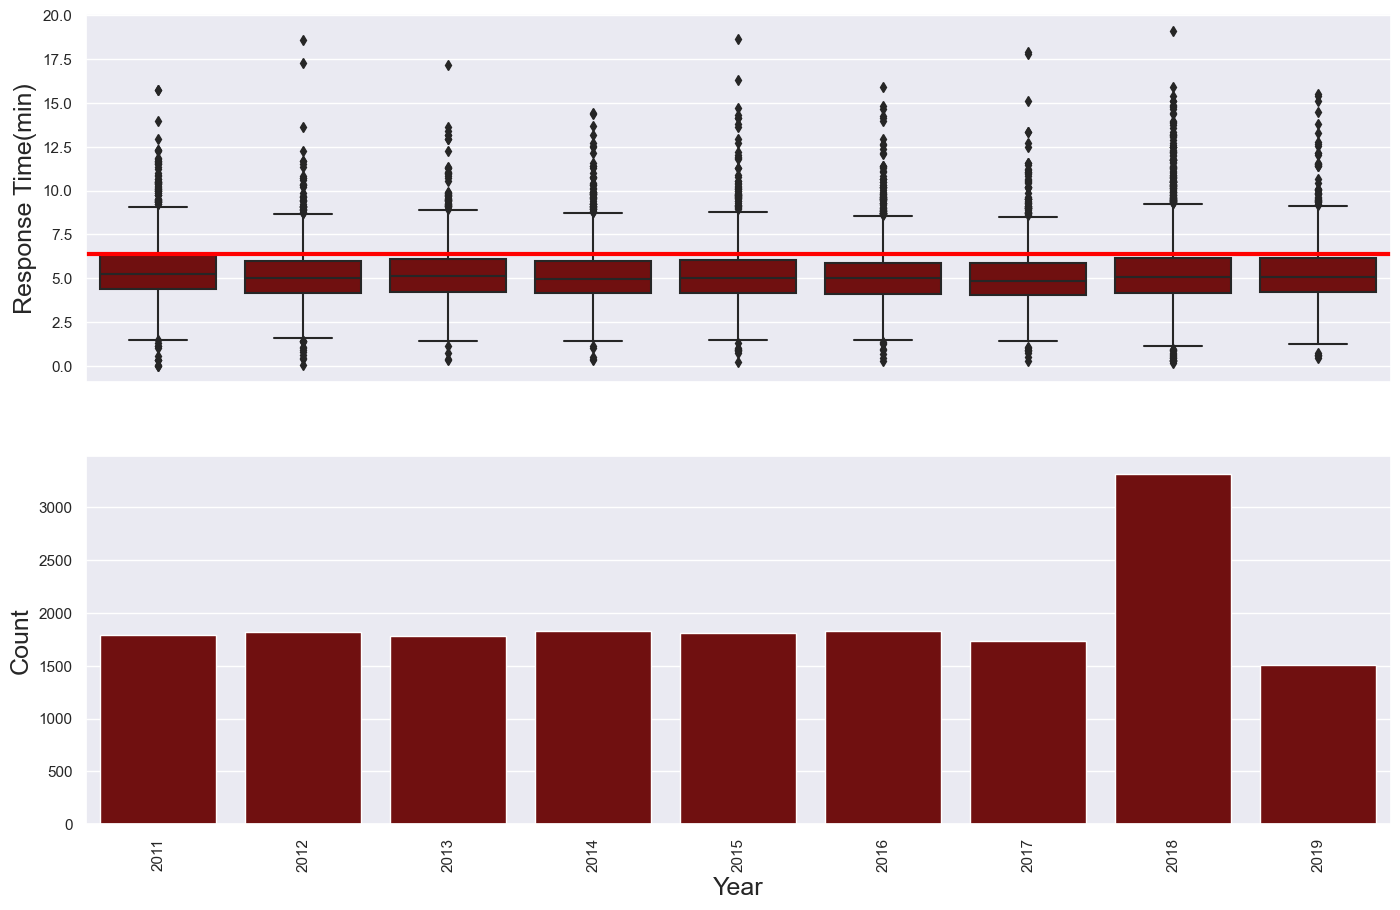

In [43]:
response_time = 6 + (24/60)

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))#subplots

fig1 = sns.boxplot(data = fire_data,
            x = 'Year',
            y = 'response_time(min)',color='maroon',
           ax = axs[0])#plotting

fig1.set_ylabel('Response Time(min)', fontsize = 18)#ylabel


sns.countplot(x = 'Year',
             data = fire_data,color='maroon',
             ax = axs[1])#plotting

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)#redline

axs[0].xaxis.set_visible(False)#hiding xgridline
axs[1].tick_params(axis = 'x', rotation = 90)#xticks
plt.xlabel('Year', fontsize = 18)#xlabel
plt.ylabel('Count', fontsize = 18)#ylabel

plt.show()

#### Hour

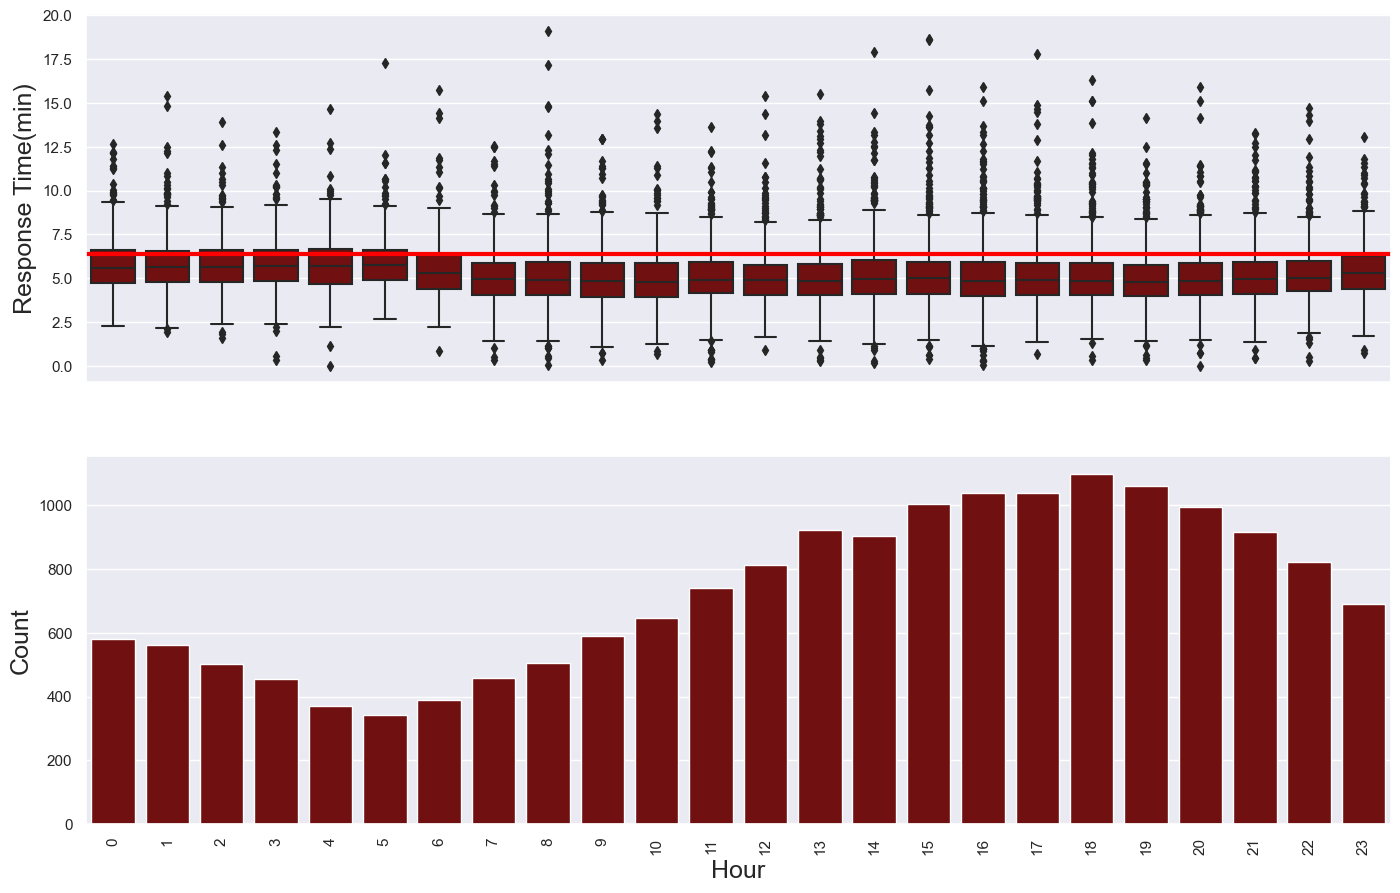

In [44]:
response_time = 6 + (24/60)

fig, axs = plt.subplots(nrows = 2, figsize = (15,10))#subplots

fig1 = sns.boxplot(data = fire_data,
            x = 'Hour',
            y = 'response_time(min)',color='maroon',
           ax = axs[0])#plotting

fig1.set_ylabel('Response Time(min)', fontsize = 18)#ylabel


sns.countplot(x = 'Hour',
             data = fire_data,color='maroon',
             ax = axs[1])#plotting

fig2 = axs[0].axhline(y = response_time,
              color = 'red',
              linewidth=3)#redline



axs[0].xaxis.set_visible(False)#hiding xgridlines
axs[1].tick_params(axis = 'x', rotation = 90)#xticks
plt.xlabel('Hour', fontsize = 18)#xlabel
plt.ylabel('Count', fontsize = 18)#ylabel

plt.show()

### Adding Dimensionality: Income Level of Wards

In [45]:
eco_data = pd.read_csv('2018-ward-profiles-2011-2016-census-25-ward-model-data.csv')#reading csv file of economic indicator of toronto ward

eco_data.head() #viewing the dataframe

City of Toronto Profiles Unnamed: 1 Unnamed: 2  \
0                       City of Toronto: City Wards         NaN        NaN   
1                                        2016 Census        NaN        NaN   
2                                                NaN        NaN        NaN   
3                                           Source:         NaN        NaN   
4  Statistics Canada, 2016 Census, Custom Tabulat...        NaN        NaN   

  Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

  Unnamed: 9  ... Unnamed: 39 Unnamed: 40 Unnamed: 41 Unnamed: 42 Unnamed: 43  \
0        NaN  ...         NaN         NaN         NaN         NaN         NaN   
1        NaN  ...         NaN         NaN         NaN         NaN         NaN   
2        NaN  ...         NaN         NaN         NaN         NaN         NaN   
3        NaN  ...         NaN         NaN         NaN         NaN         NaN   
4        NaN  ...         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 44 Unnamed: 45 Unnamed: 46 Unnamed: 47 Unnamed: 48  
0         NaN         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN         NaN  

[5 rows x 49 columns]

In [46]:
eco_dataclean = eco_data.iloc[1248]#specific column with the average income levels
eco_data.head() #viewing the dataframe

City of Toronto Profiles Unnamed: 1 Unnamed: 2  \
0                       City of Toronto: City Wards         NaN        NaN   
1                                        2016 Census        NaN        NaN   
2                                                NaN        NaN        NaN   
3                                           Source:         NaN        NaN   
4  Statistics Canada, 2016 Census, Custom Tabulat...        NaN        NaN   

  Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

  Unnamed: 9  ... Unnamed: 39 Unnamed: 40 Unnamed: 41 Unnamed: 42 Unnamed: 43  \
0        NaN  ...         NaN         NaN         NaN         NaN         NaN   
1        NaN  ...         NaN         NaN         NaN         NaN         NaN   
2        NaN  ...         NaN         NaN         NaN         NaN         NaN   
3        NaN  ...         NaN         NaN         NaN         NaN         NaN   
4        NaN  ...         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 44 Unnamed: 45 Unnamed: 46 Unnamed: 47 Unnamed: 48  
0         NaN         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN         NaN  

[5 rows x 49 columns]

In [47]:
eco_dataclean = eco_dataclean.dropna()#dropping all NAN values
eco_dataclean.drop('City of Toronto Profiles', inplace=True)#dropping unwanted rows
eco_dataclean.drop('Unnamed: 1', inplace=True)#dropping unwanted rows

In [48]:
eco_dataclean.reset_index()#resetting index

index    1248
0    Unnamed: 2   73374
1    Unnamed: 3  128448
2    Unnamed: 4  105994
3    Unnamed: 5   99784
4    Unnamed: 6   67954
5    Unnamed: 7   86717
6    Unnamed: 8   65458
7    Unnamed: 9  162674
8   Unnamed: 10   80807
9   Unnamed: 11  103047
10  Unnamed: 12  170832
11  Unnamed: 13  155470
12  Unnamed: 14   75382
13  Unnamed: 15  101323
14  Unnamed: 16  216158
15  Unnamed: 17   80648
16  Unnamed: 18   87491
17  Unnamed: 19   87416
18  Unnamed: 20  104123
19  Unnamed: 21   78561
20  Unnamed: 22   70624
21  Unnamed: 23   75768
22  Unnamed: 24   78984
23  Unnamed: 25   72289
24  Unnamed: 26   99715

In [49]:
eco_dataclean.reset_index(drop=True, inplace=True)#resetting index

In [50]:
eco_dataclean = pd.DataFrame(eco_dataclean)#converrting to dataframe
eco_dataclean = eco_dataclean.rename(columns={1248: 'Average Income'})#renaming column
eco_dataclean.index += 1 
eco_dataclean.index.names = ['Ward']#making the index name as ward
eco_dataclean.head()#viewing the dataframe

Average Income
Ward               
1             73374
2            128448
3            105994
4             99784
5             67954

(array([     0.,  50000., 100000., 150000., 200000., 250000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

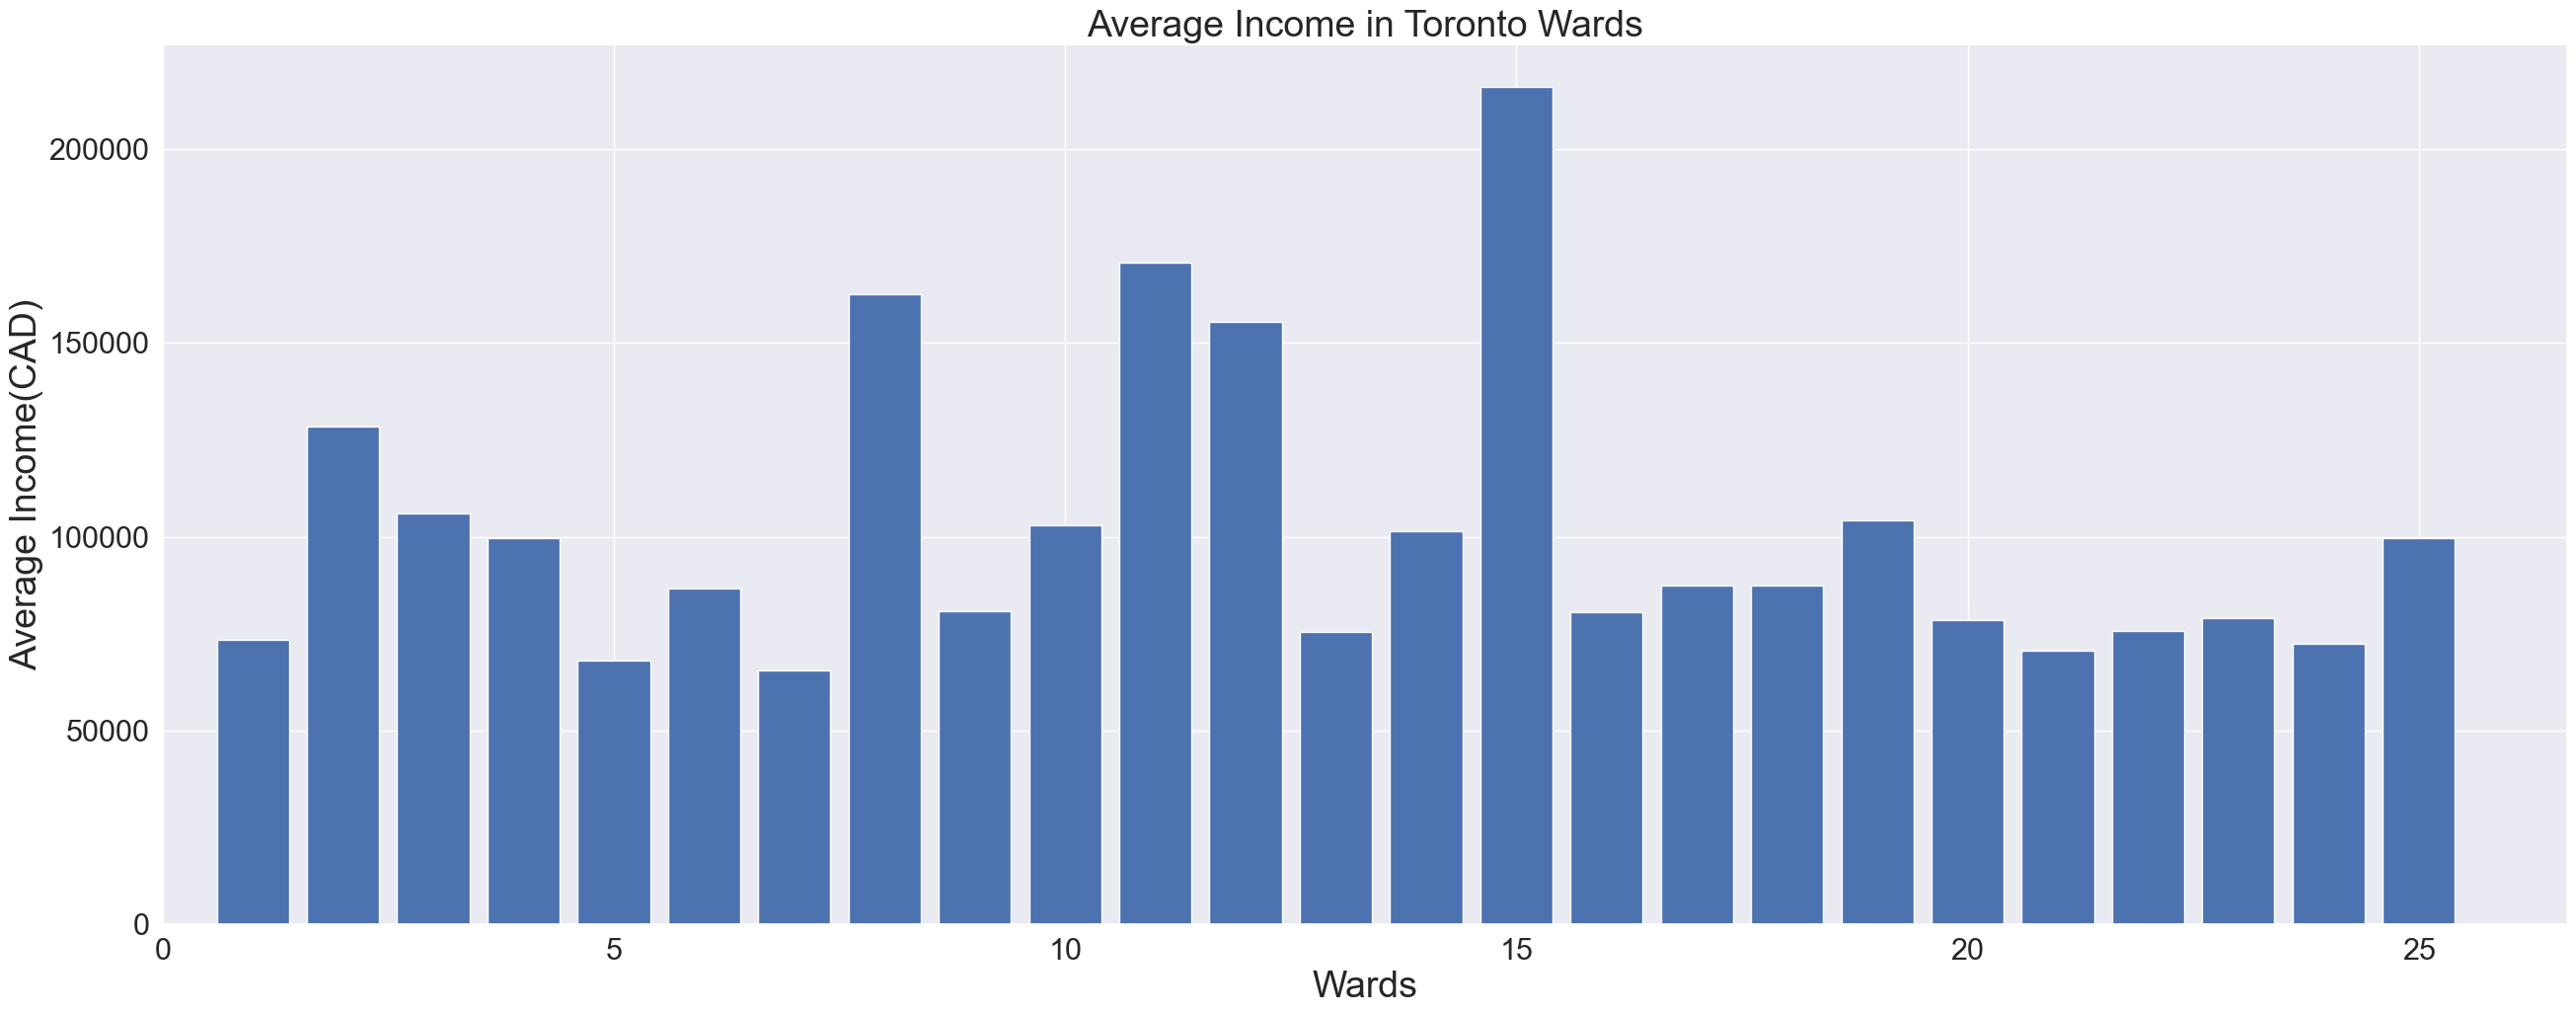

In [51]:
eco_dataclean['Average Income'] = eco_dataclean['Average Income'].astype(int) #converting all the income values as int values
fig1 = plt.bar(eco_dataclean.index, eco_dataclean['Average Income'])#plotting all values
fig1 = plt.xlabel('Wards' ,  fontsize = 27)#xlabel
fig1 = plt.ylabel('Average Income(CAD)',  fontsize = 27)#ylabel
fig1 = plt.title('Average Income in Toronto Wards',  fontsize = 27)#title
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)
plt.xticks(fontsize=22)#xticks font
plt.yticks(fontsize=22)#xticks font

## Predictive Model

In [52]:
# Adding binary features, like whether the fire occurred on a weekend or weekday, or whether the fire was during the day or at night
day_time = np.arange(7,22,1)
weekend = ['Sat','Sun']
fire_data['day_time'] = fire_data['Hour'].isin(day_time).astype('int')
fire_data['weekend'] = fire_data['Day of Week'].isin(weekend).astype('int')

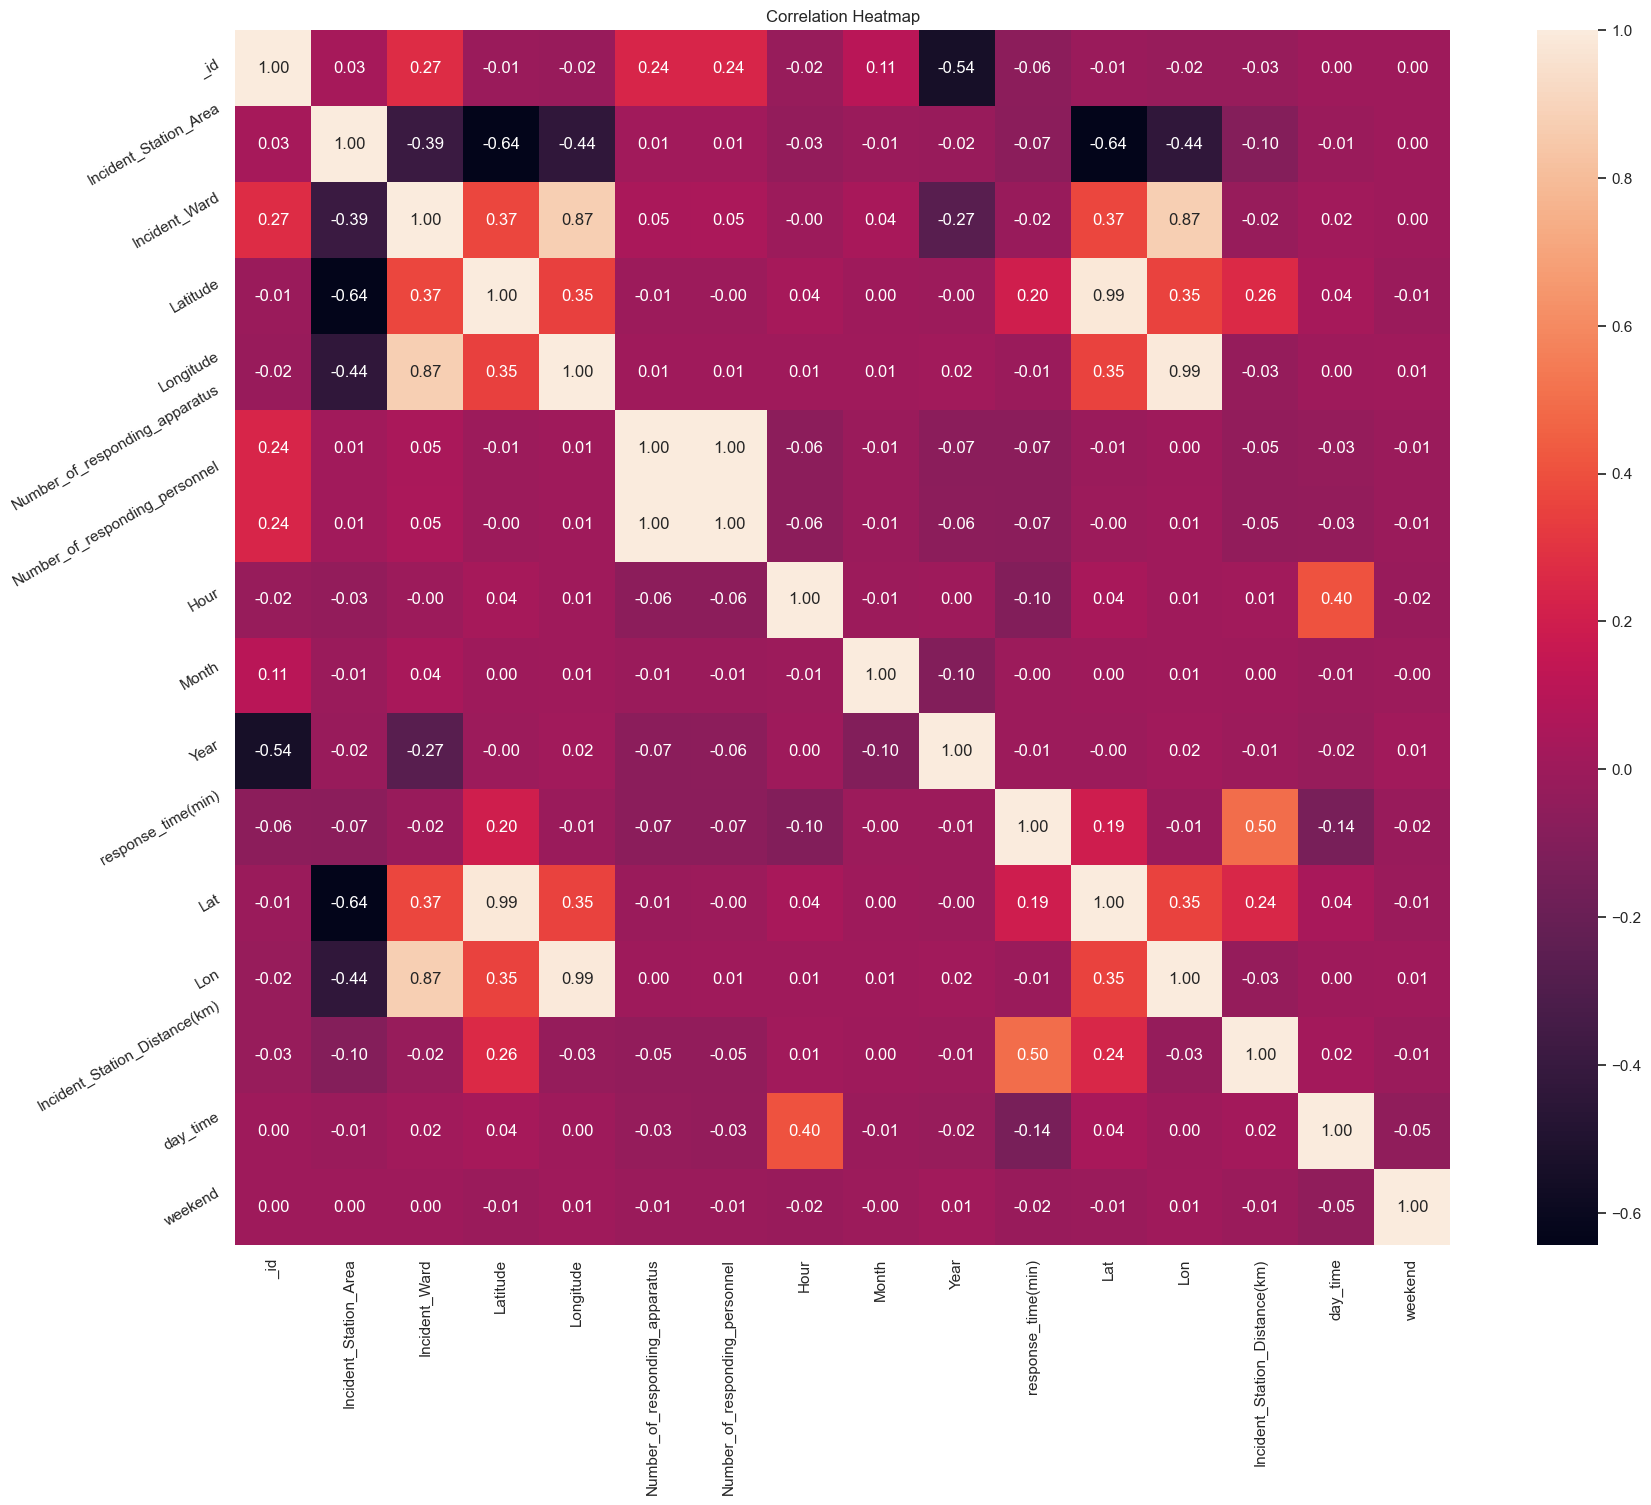

In [53]:
correlation = fire_data.corr()

#graphing the matrix
plt.figure(figsize=(20,15))
plt.title('Correlation Heatmap')#title
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

In [54]:
#define a function to calculate the cross validated RMSE of different models

def models_rmse(models,X_train,y_train,tags):

#takes a set of training data, a list of models, and their tags, to display the cross validated RMSE of different models
    
    for model,tag in zip(models,tags):
        #evaluate the average k-fold score (RMSE) of the model
        error = ((-cross_val_score(model,X_train,y_train,scoring = 'neg_mean_squared_error',cv = 2))**0.5).mean()
        print("Root_Mean_Square_Error for %s, : %.6f"%(tag, error))

# Predict response time
# The top 5 features are selected best on corrolation matrix and resultant error of the mdoel
X = fire_data[['Incident_Station_Distance(km)','Hour', 'day_time', 'Number_of_responding_personnel', 'Number_of_responding_apparatus']]
y = fire_data[['response_time(min)']]

# standardize the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the data into train and test
# Create training set
X_train, X_rem, y_train, y_rem = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
# Create validation and test set
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, random_state=0)

models =[LinearRegression(),linear_model.Ridge(),\
             neighbors.KNeighborsRegressor(5,weights='uniform'), linear_model.BayesianRidge(),\
             tree.DecisionTreeRegressor(max_depth=5)]
tags = ["LinearRegression","Ridge", 'knn5', "BayesianRidge", 'tree4']
models_rmse(models,X,y,tags)

Root_Mean_Square_Error for LinearRegression, : 1.453942
Root_Mean_Square_Error for Ridge, : 1.453941
Root_Mean_Square_Error for knn5, : 1.561427
Root_Mean_Square_Error for BayesianRidge, : 1.453940
Root_Mean_Square_Error for tree4, : 1.438947


In [55]:
# 1 ---- Building the ML Model
# Create Decision Tree Regressor
reg = tree.DecisionTreeRegressor()
# Train Decision Tree Regressor
reg = reg.fit(X_train, y_train)
#Predict the response for validation dataset
y_pred = reg.predict(X_val)

# Evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_val, y_pred))

reg.feature_importances_

Mean Absolute Error: 1.434400484199796
Mean Squared Error: 4.122704206898669
Root Mean Squared Error: 2.0304443373061645
Mean Absolute Percentage Error: 0.387964567797699


array([0.65074224, 0.17169099, 0.01246807, 0.10909418, 0.05600453])

Text(0, 0.5, 'Mean Square Error')

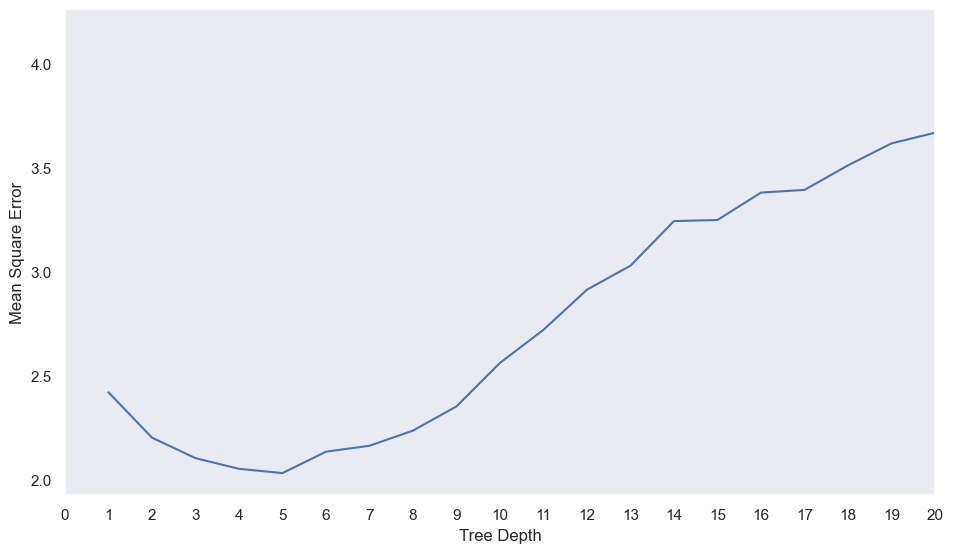

In [56]:
# Tuning max depth of the tree
mses = []
for depth in range(1, (reg.tree_.max_depth + 1)):
    d_tree_reg = tree.DecisionTreeRegressor(max_depth=depth)
    d_tree_reg.fit(X_train, y_train)
    tree_predictions = d_tree_reg.predict(X_val)
    mses.append(mean_squared_error(y_val, tree_predictions))
tree_depths = [depth for depth in range(1, (reg.tree_.max_depth + 1))]
plt.figure(figsize=(10,6))

plt.grid()
plt.plot(tree_depths, mses)
plt.xlabel("Tree Depth")
plt.xlim(0,20,1)
plt.xticks(range(0,21))
plt.ylabel("Mean Square Error")

In [57]:
# 2---- Create Decision Tree Regressor using max depth = 5
reg = tree.DecisionTreeRegressor(max_depth=5, random_state=0)
# Train Decision Tree Regressor
reg = reg.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = reg.predict(X_val)

# Evaluating the model
from sklearn.metrics import mean_squared_error
# mean_squared_error(y_val, y_pred, squared=False)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_val, y_pred))

Mean Absolute Error: 0.9992549001010127
Mean Squared Error: 2.034202998452727
Root Mean Squared Error: 1.4262548855140609
Mean Absolute Percentage Error: 0.26009009947300893


In [58]:
# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5],
           "min_samples_leaf":[1,2,3,4,5,6],
           "min_weight_fraction_leaf":[0.01,0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80] }

# calculating different regression metrics
from sklearn.model_selection import GridSearchCV
grid_search=GridSearchCV(reg,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)
grid_search.fit(X_train, y_train)
# best hyperparameters 
grid_search.best_params_

Fitting 3 folds for each of 7776 candidates, totalling 23328 fits
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] E

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] E

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_de

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_de

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_dept

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_dep

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_

[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] E

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] E

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] E

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_dept

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_dep

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_de

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_d

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_dep

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max

[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_dept

[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] E

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] E

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] E

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_dep

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_d

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_d

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_dep

[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_dept

[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.816 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.684 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] E

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] E

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] E

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_d

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_d

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_de

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_dep

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_dep

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_dept

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_dept

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_dept

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.913 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=1, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.824 total time=   0.0s
[CV 2/

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] E

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.824 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.727 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.893 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_dep

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.739 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.562 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.812 total time=   0.0s
[CV 1/3] END max

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_dept

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.739 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.562 total time=   0.0s
[CV 3/3] END max_

[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.739 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.562 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.812 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.172 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.284 total time=   0.0s
[CV 1/3] END max_de

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.739 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.562 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.812 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_

[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] E

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] E

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] E

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_de

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.344 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_d

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.344 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.344 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.344 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_d

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_de

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_dep

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.344 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max

[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_de

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_dep

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] E

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] E

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.733 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.892 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3]

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] E

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_dep

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.344 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_d

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_dep

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_dep

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_dept

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_dept

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_dep

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_dept

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.344 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.530 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.447 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.565 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.306 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.245 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.344 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_d

[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] E

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] E

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END 

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.739 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.562 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.812 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.172 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.284 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.812 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.172 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.284 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_dept

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.172 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.284 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.739 total time=   0.0s
[CV 2/3] END max_d

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.172 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.284 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.739 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.562 total time=   0.0s
[CV 3/3] END max_

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.193 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.130 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.192 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.739 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.562 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.812 total time=   0.0s
[CV 1/3] END max

[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=3, max_features=None, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.318 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.248 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.824 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] E

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] E

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.280 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.280 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.074 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_dep

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.074 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_d

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.074 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.296 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.815 total time=   0.0s
[CV 1/3] END max

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.074 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_d

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.074 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_de

[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.074 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_de

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.074 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.296 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.815 total time=   0.0s
[CV 1/3] END max

[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.726 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.868 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.494 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.422 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.512 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3]

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.279 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.164 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.191 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.816 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.726 total time=   0.0s
[CV 3

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] E

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.649 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_dep

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.238 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.119 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.282 total time=   0.0s
[CV 1/3] END max_de

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.204 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.108 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_dept

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.204 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.108 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_d

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.108 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.204 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.108 total time=   0.0s
[CV 3/3] END max_dep

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_d

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.204 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.108 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=log2, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.191 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.816 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.726 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.868 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.494 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.422 total time=   0.0s
[CV 3/

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.279 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.164 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.191 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.816 total time=   0.0s
[CV 2/

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] E

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_dept

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.119 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.282 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.238 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.119 total time=   0.0s
[CV 3/3] END max_dep

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.108 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.204 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.108 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.672 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_dept

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.204 total time=   0.0s
[CV 2/3] END max_dept

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.813 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.721 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.861 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.204 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.108 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.899 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.780 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.681 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.546 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.737 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.625 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.531 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.258 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.825 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.650 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.501 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=sqrt, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.432 total time=   0.0s
[CV 3/3] END max_d

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] E

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.318 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.248 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.824 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.162 total time=   0.0s
[CV 3/

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] E

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.162 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.280 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth

[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.280 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.075 total time=   0.0s
[CV 2/3] END max_dept

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.229 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.074 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.296 total time=   0.0s
[CV 3/3] END max_

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.335 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.839 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.749 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.296 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.296 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.162 total time=   0.0s
[CV 3/3] END max_d

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-2.898 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.019 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.296 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=best;, score=-2.070 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.477 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.296 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.162 total time=   0.0s
[CV 3/3] END max_d

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.440 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.01, splitter=random;, score=-2.815 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.215 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.162 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.280 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_dept

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.359 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best;, score=-2.487 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.162 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=-2.280 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.838 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.750 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=-2.826 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-2.273 total time=   0.0s
[CV 2/3] END max_depth

[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.473 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.779 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best;, score=-2.953 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=None, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random;, score=-2.893 total time=   0.0s
[CV 2/3] END max_depth

{'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.01,
 'splitter': 'best'}

In [59]:
# 3---- Optimize Decision Tree Regressor using hyperparameter tuning
reg = tree.DecisionTreeRegressor(max_depth=5,max_features='auto',max_leaf_nodes =None, min_samples_leaf=1,min_weight_fraction_leaf=0.01,splitter='best')
# Train Decision Tree Regressor
reg = reg.fit(X_train, y_train)
#Predict the response for validation dataset
y_pred = reg.predict(X_val)

# Evaluating the model
from sklearn.metrics import mean_squared_error
# mean_squared_error(y_val, y_pred, squared=False)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_val, y_pred))

Mean Absolute Error: 0.9998846906120947
Mean Squared Error: 2.0260556101736773
Root Mean Squared Error: 1.4233958023591602
Mean Absolute Percentage Error: 0.2611274127143467


In [60]:
#Predict the response for test dataset
y_pred_test = reg.predict(X_test)

# Evaluating the model
from sklearn.metrics import mean_squared_error
# mean_squared_error(y_val, y_pred, squared=False)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred_test))

Mean Absolute Error: 0.9507471393657994
Mean Squared Error: 1.8899094706392792
Root Mean Squared Error: 1.374739782882302
Mean Absolute Percentage Error: 0.36029280240985134


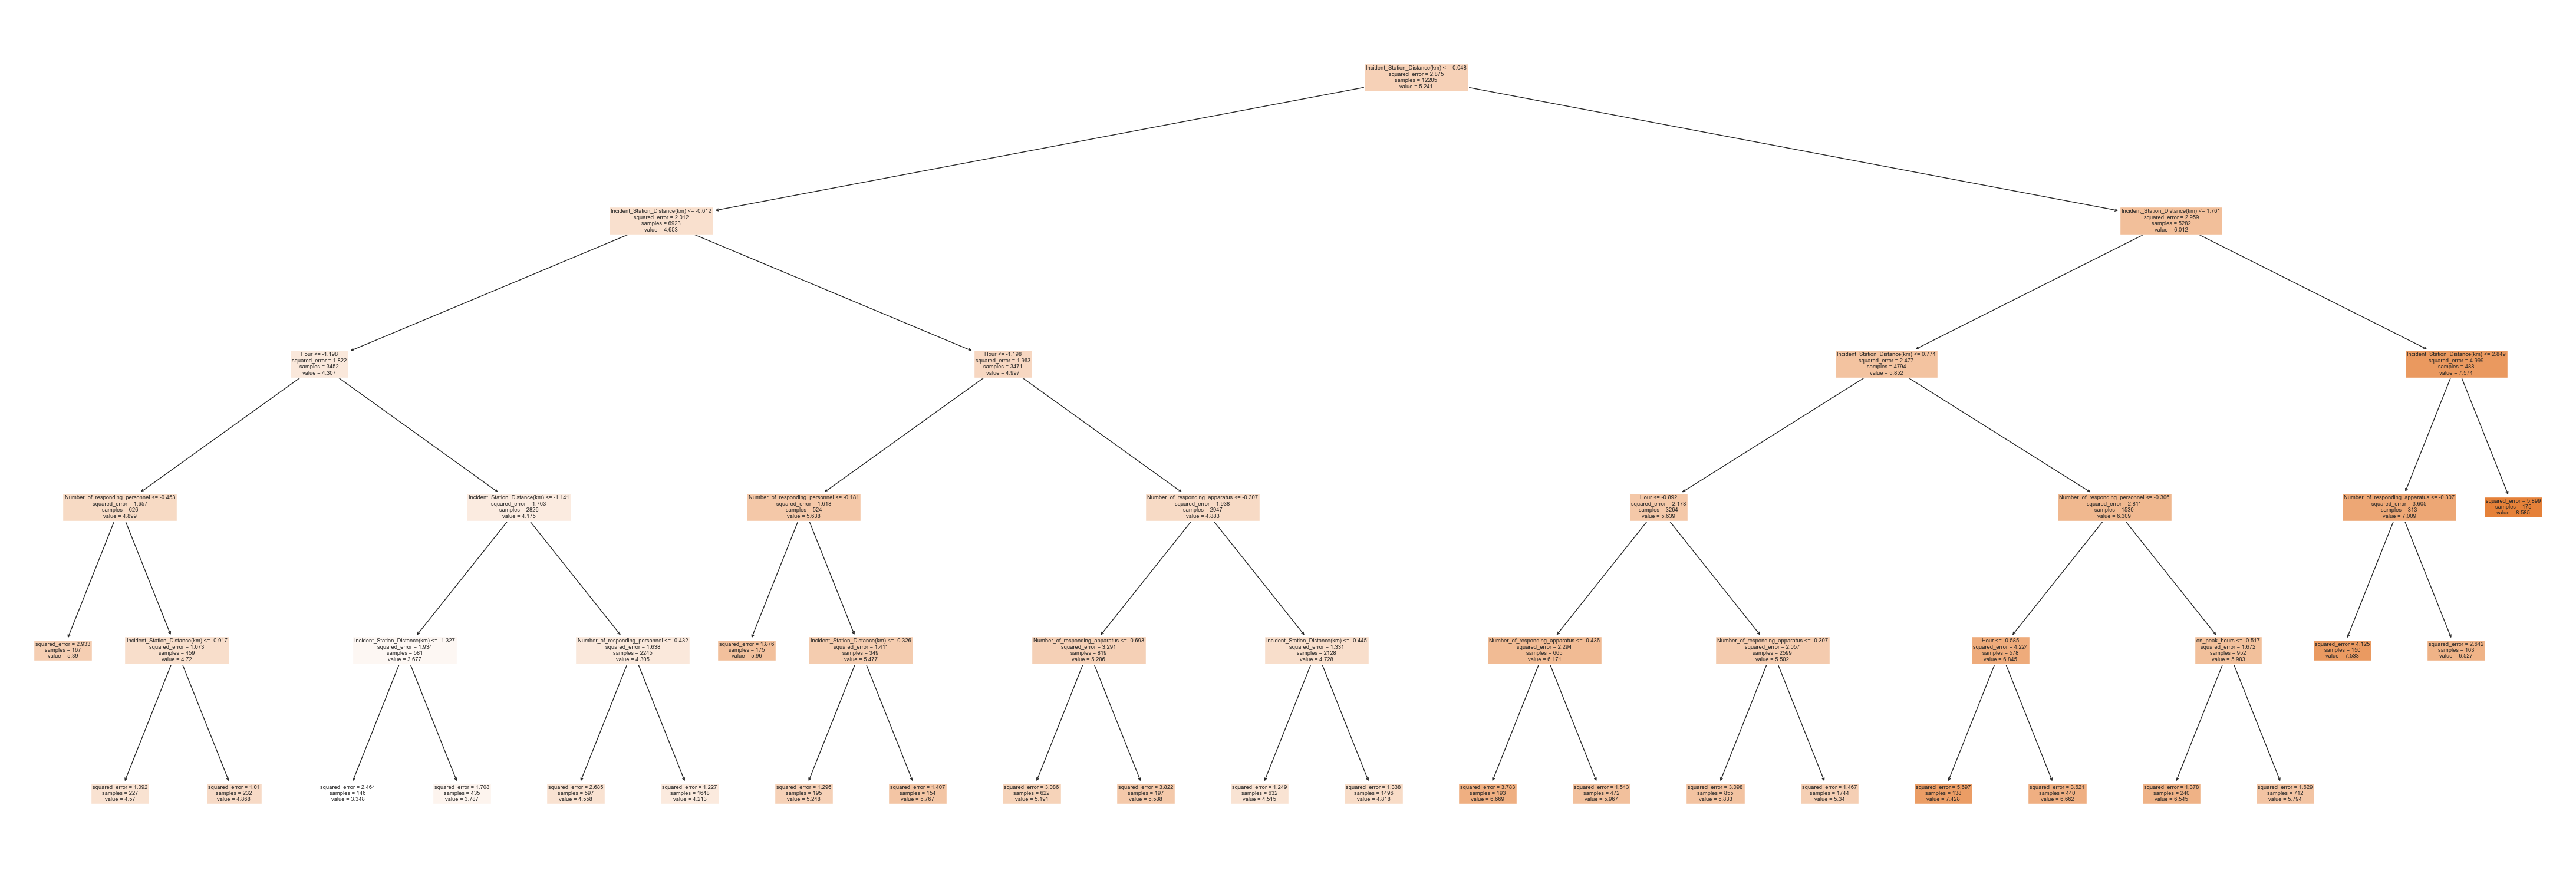

In [61]:
# Visualize the tree
from sklearn import tree
import PIL 
from PIL import Image

fig = plt.figure(figsize=(50,18))
features = ['Incident_Station_Distance(km)','Hour', 'on_peak_hours', 'Number_of_responding_personnel', 'Number_of_responding_apparatus']
_ = tree.plot_tree(reg, 
                   feature_names=features,  
                   class_names=y_test,
                   filled=True)